In [105]:
import copulas
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from pathlib import Path
from datetime import date
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import rankdata
from scipy.stats import norm

from copulas.multivariate import GaussianMultivariate

from copulas.visualization import compare_3d
from copulas.bivariate import Bivariate
from copulas.multivariate import GaussianMultivariate as TCopula

Crear cartera equiponderada (sin rebalanceos) compuesta por: 
AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GLD, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM, bono del gobierno americano a 10 años, bono del gobierno americano a 2 años y HYG (BAMLH0A0HYM2). 

Fase 1: Detectando el 'Pulso' del Mercado (Hidden Markov Models) 
Objetivo: Considerando la existencia de dos estados de mercado (calma y crisis), identifica, 
para cada día, en qué estado se encuentra el mercado. 
• Tarea  Técnica:  Ajustar  un  modelo  Gaussian  HMM  (Hidden  Markov  Model)  de  2 
estados sobre la serie de retornos multivariante y/o sobre factores representativos. 
• Output Visual: Gráfico del S&P 500 coloreado según el régimen detectado (Blanco = 
Calma, Azul = Crisis).

In [45]:
import sys
print(sys.executable)

/Users/emiliosanchez/Desktop/taller_riesgos/Practica-MIAX-gestion-de-riesgos/taller_riesgos_venv/bin/python


In [46]:
date_init = '2005-12-01'
symbols = ['AAPL','AMZN','BAC','BRK-B','CVX','ENPH','GLD','GME','GOOGL','JNJ','JPM','MSFT','NVDA','PG','XOM']
bons = ['DGS10', 'DGS2']
hyg = 'BAMLH0A0HYM2'

In [47]:
# descargar precios ajustados desde Yahoo hasta hoy
end = pd.Timestamp.today().normalize()
sp500 = yf.download('^GSPC', start=date_init, end=end, auto_adjust=True, progress=False)

if isinstance(sp500.columns, pd.MultiIndex):
     sp500.columns = sp500.columns.get_level_values(0)

sp500.index.name = None

# normalizar columnas
sp500 = sp500.rename(columns=str.lower).reset_index()
sp500 = sp500.rename(columns={'index': 'date'})
# calcular retornos
sp500['ret_close'] = sp500['close'].pct_change().dropna()

# quedarnos solo con las 3 columnas deseadas
returns = sp500[['date', 'ret_close']].dropna().copy()

returns.head()




Price,date,ret_close
1,2005-12-02,0.000324
2,2005-12-05,-0.002363
3,2005-12-06,0.001276
4,2005-12-07,-0.005009
5,2005-12-08,-0.001217


El ratio de Amihud captura cuánto se mueve el precio por unidad de volumen negociado:
Amihud_t = |R_t| / Volumen_t
- Si el precio cambia mucho con poco volumen → mercado ilíquido → Amihud alto
- Si el precio cambia poco con mucho volumen → mercado líquido → Amihud bajo
SPY es uno de los activos más líquidos del mundo, así que sus valores de Amihud son extremadamente bajos.

USAR COMO FEATURE DE LIQUIDEZ EM HMM

In [48]:
spy = yf.download('SPY', start=date_init, end=end, auto_adjust=True, progress=False)
spy = spy.rename(columns=str.lower)
spy.index.name = 'date'

spy_ret = spy['close'].pct_change().dropna()

spy_vol = spy['volume']

amihud_spy = (spy_ret['spy'].abs() / spy_vol['spy']).to_frame(name='amihud_sp500')
amihud_spy = amihud_spy.reset_index() 
amihud_spy.head()

,date,amihud_sp500
0,2005-12-01,NaN
1,2005-12-02,2.704996e-11
2,2005-12-05,3.591110e-11
3,2005-12-06,3.272679e-11
4,2005-12-07,8.732788e-11


CONEXIÓN CON LA FRED PARA BAJAR DATOS

In [49]:
BASE_URL = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='

def download_fred(serie):
    '''
    Descarga cualquier serie de FRED usando solo pandas.
    serie: código de la serie en FRED (ej: 'DGS10', 'DGS2', 'VIXCLS')
    '''
    url = BASE_URL + serie
    df = pd.read_csv(url)

    # FRED usa 'observation_date' como nombre de columna cambio por 'date' y convertir a datetime
    df.rename(columns={'observation_date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])

    # Filtrar por fecha de inicio date_init
    df = df[df['date'] >= pd.to_datetime(date_init)]


    # Calcular cambio diario
    df[f'{serie}_change'] = df[serie].diff()

    return df


Descarga del Vix:
VIX < 15: Mercado tranquilo
VIX 15-25: Volatilidad normal
VIX 25-35: Nerviosismo
VIX > 35: Pánico/crisis

In [50]:
vixcls = download_fred('VIXCLS')
vixcls.head()


,date,VIXCLS,VIXCLS_change
4152,2005-12-01,11.24,NaN
4153,2005-12-02,11.01,-0.23
4154,2005-12-05,11.60,0.59
4155,2005-12-06,11.52,-0.08
4156,2005-12-07,12.18,0.66


Bono USA 10 años

In [51]:
dgs10 = download_fred('DGS10')
dgs10.head()

,date,DGS10,DGS10_change
11457,2005-12-01,4.52,NaN
11458,2005-12-02,4.52,0.00
11459,2005-12-05,4.57,0.05
11460,2005-12-06,4.49,-0.08
11461,2005-12-07,4.52,0.03


Bono USA 2 años

In [52]:
dgs2 = download_fred('DGS2')
dgs2.head()

,date,DGS2,DGS2_change
7697,2005-12-01,4.45,NaN
7698,2005-12-02,4.43,-0.02
7699,2005-12-05,4.47,0.04
7700,2005-12-06,4.42,-0.05
7701,2005-12-07,4.42,0.00


Bonos high yield

In [53]:
hy_oas = download_fred('BAMLH0A0HYM2')
hy_oas.head()

,date,BAMLH0A0HYM2,BAMLH0A0HYM2_change
2357,2005-12-01,3.62,NaN
2358,2005-12-02,3.63,0.01
2359,2005-12-05,3.62,-0.01
2360,2005-12-06,3.68,0.06
2361,2005-12-07,3.66,-0.02


Nos gustaría usar el PMI, pero no es fácil de obtener:

Uso Chicago PMI com proxy porque no esta disponible PMI desde 2003. 
CFNAI =  Chicago Fed National Activity Index. 
Es un idice de 85 indicadores económocos de EEUU. Su objetivo es medir si la economía está por encima de la tendencia histórica o por debajo. Si su valor es menor a  -0.7 es una clara señal de recesión. La versión MA3, es la media movila a 3 meses, se usa en análisis macro porque es más estable y menos ruidosa. 

Calma-> valores cercanos a 0 
Crisis -> Valores menores de -0.7



-Por qué la usamos?-> Gratis y fácil de obtener, Alta correlación con el PMI , además el PMI calcula toda la economía, no solo la manufacturera

In [54]:
pmi = download_fred('CFNAIMA3')
pmi_daily = (
    pmi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

pmi_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,CFNAIMA3,CFNAIMA3_change
0,2005-12-01,0.57,NaN
1,2005-12-02,0.57,NaN
2,2005-12-03,0.57,NaN
3,2005-12-04,0.57,NaN
4,2005-12-05,0.57,NaN



CONSUMER PRICE INDEX

CPI es una medida mensual, indica los indice de precios de consumo, la pérdida o ganancia de poder adquisitivo de los hogares

cpi_daily = cpi.set_index("date").resample("D").ffill().reset_index()

El CPI es una cantidad que en el 84 se normalizó a 100. Lo que nos da es un valor. la variación de ete CPI es la inflación



In [55]:
cpi = download_fred('CPIAUCSL')
cpi_daily = (
    cpi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

cpi_daily.head() #Todos los datos de diciembre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.


,date,CPIAUCSL,CPIAUCSL_change
0,2005-12-01,198.1,NaN
1,2005-12-02,198.1,NaN
2,2005-12-03,198.1,NaN
3,2005-12-04,198.1,NaN
4,2005-12-05,198.1,NaN


Unemployment Rate->Porcentaje de fuerza laboral que está desempleada (El paro de USA)

se considera una crisis severa unas tasas de paro superiores al 8% y señal de debilidad por encima del 6%

In [56]:
unrate = download_fred('UNRATE')

unrate_daily = (
    unrate
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

unrate_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,UNRATE,UNRATE_change
0,2005-12-01,4.9,NaN
1,2005-12-02,4.9,NaN
2,2005-12-03,4.9,NaN
3,2005-12-04,4.9,NaN
4,2005-12-05,4.9,NaN


El Put/Call Ratio mide el volumen relativo de opciones put frente a opciones call.
Es uno de los indicadores de sentimiento más usados:
- MAyor que 2 -> Pánico
- Mayor que 1.0 → sentimiento bajista (más puts que calls)
- Menos que 0.7 → sentimiento alcista (más calls que puts)
- Entre 0.7 y 1.0 → neutral

El VIX comple una función muy similar


Cálculo del DF final con todos los elementos que hemos descargado:



In [57]:
df_final = (
    returns
    .merge(sp500[['date', 'close']], on='date', how='left')
    .merge(amihud_spy[['date', 'amihud_sp500']], on='date', how='left')
    .merge(vixcls[['date','VIXCLS', 'VIXCLS_change']], on='date', how='left')
    .merge(dgs10[['date', 'DGS10', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date','BAMLH0A0HYM2', 'BAMLH0A0HYM2_change']], on='date', how='left')
    .merge(pmi_daily[['date', 'CFNAIMA3_change']], on='date', how='left')
    .merge(cpi_daily[['date', 'CPIAUCSL_change']], on='date', how='left')
    .merge(unrate_daily[['date', 'UNRATE_change']], on='date', how='left')
)
df_final = df_final[df_final['date'] >= '2006-01-01']
df_final.head(500)


,date,ret_close,close,amihud_sp500,VIXCLS,VIXCLS_change,DGS10,DGS10_change,DGS2,DGS2_change,BAMLH0A0HYM2,BAMLH0A0HYM2_change,CFNAIMA3_change,CPIAUCSL_change,UNRATE_change
20,2006-01-03,0.016430,1268.800049,2.400988e-10,11.14,NaN,4.37,NaN,4.34,NaN,3.73,NaN,-0.05,1.200,-0.2
21,2006-01-04,0.003673,1273.459961,9.123892e-11,11.37,0.23,4.36,-0.01,4.31,-0.03,3.69,-0.04,-0.05,1.200,-0.2
22,2006-01-05,0.000016,1273.479980,1.329050e-11,11.31,-0.06,4.36,0.00,4.32,0.01,3.64,-0.05,-0.05,1.200,-0.2
23,2006-01-06,0.009399,1285.449951,1.323248e-10,11.00,-0.31,4.38,0.02,4.36,0.04,3.56,-0.08,-0.05,1.200,-0.2
24,2006-01-09,0.003656,1290.150024,5.903525e-11,11.13,0.13,4.38,0.00,4.36,0.00,3.51,-0.05,-0.05,1.200,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,2007-12-20,0.004900,1460.119995,2.935930e-11,20.58,-1.10,4.04,-0.02,3.09,-0.03,5.79,0.08,-0.13,0.611,0.3
516,2007-12-21,0.016670,1484.459961,9.867612e-11,18.47,-2.11,4.18,0.14,3.19,0.10,5.68,-0.11,-0.13,0.611,0.3
517,2007-12-24,0.008077,1496.449951,1.628476e-10,18.60,0.13,4.23,0.05,3.24,0.05,5.65,-0.03,-0.13,0.611,0.3
518,2007-12-26,0.000809,1497.660034,3.195786e-11,18.66,NaN,4.30,NaN,3.31,NaN,5.59,NaN,-0.13,0.611,0.3


Creamos features adicionales: resta de los tipos a 10 y 2 años y cambio de esta resta


In [58]:
df_final['yield_curve'] = df_final['DGS10'] - df_final['DGS2']

# Cambio de la pendiente
df_final['yield_curve_change'] = df_final['yield_curve'].diff()

Con los datos obtenidos se procede a aplicar el modelo modelo  Gaussian  HMM. 

In [59]:
features = [
    'ret_close',                # 1. Retorno S&P
    'amihud_sp500',             # 2. Liquidez
    'VIXCLS',                   # 3. Nivel volatilidad (añadido)
    'VIXCLS_change',            # 4. Cambio volatilidad
    'yield_curve',              # 5. Pendiente curva tipos (añadido)
    'yield_curve_change',       # 6. Cambio pendiente
    'BAMLH0A0HYM2',            # 7. Nivel spread HY
    'BAMLH0A0HYM2_change',     # 8. Cambio spread HY
    'CFNAIMA3_change',         # 9. Actividad económica
    'CPIAUCSL_change',         # 10. Inflación
    'UNRATE_change'            # 11. Desempleo
]
df_final = df_final.sort_values("date").set_index("date")

df_final = df_final.bfill() #sustituye los valores faltantes anteriores
df_final = df_final.ffill() #sustituye los valores faltantes posteriores

df_final = df_final.reset_index()

df_to_HMM = df_final[features].values

Normalizamos todos los valores que tenemos en nuestro df 

In [60]:
scaler = StandardScaler()

# Ajustar y transformar
df_to_HMM_scaled = scaler.fit_transform(df_to_HMM)

Aplicamos el Gausian HMM

In [61]:
model = GaussianHMM(
    n_components=2,        # número de regímenes Calma/Crisis
    covariance_type='full',
    n_iter=500,
    random_state=42
)

model.fit(df_to_HMM_scaled)


,n_components,2
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [62]:
df_final["regime"] = model.predict(df_to_HMM_scaled)

In [63]:
stats = df_final.groupby("regime")["ret_close"].agg(["mean", "std"])

stats["sharpe"] = stats["mean"] / stats["std"]
crisis_state = stats["sharpe"].idxmin()
calm_state   = stats["sharpe"].idxmax()
print(f"Crisis es {crisis_state}, Calma es {calm_state}")
print(f"Numero de días por estado: {df_final['regime'].value_counts()}")

Crisis es 1, Calma es 0
Numero de días por estado: regime
0    4318
1     740
Name: count, dtype: int64


In [64]:
df_final["regime_shift"] = df_final["regime"].diff().fillna(0).abs()
num_shifts = df_final["regime_shift"].sum()

print("Número de cambios de estado:", int(num_shifts))


Número de cambios de estado: 108


In [65]:
df_final["regime_run"] = (df_final["regime"] != df_final["regime"].shift()).cumsum() #contador para cambios de régimen
durations = df_final.groupby(["regime", "regime_run"]).size() #duración de cada período de régimen

durations



regime  regime_run
0       1             101
        3             304
        5              59
        7               6
        9              38
                     ... 
1       100             5
        102             3
        104            15
        106             1
        108             2
Length: 109, dtype: int64

In [66]:
durations.groupby(level=0).mean() #duración media de cada régimen


regime
0    78.509091
1    13.703704
dtype: float64

In [67]:
crisis_durations = durations.loc[crisis_state]

valid_runs = crisis_durations[crisis_durations > 3].index # MAYOR A 3 LO HE PUESTO SIN CRTITERIO; PARA ELIMINAR EPISODIOS MUY CORTOS QUE NO PARECEN CRISIS REALES


In [68]:
MIN_CRISIS_DAYS= 30

crisis_periods = []
current_start = None
current_run = None

for i in range(len(df_final)):
    regime = df_final["regime"].iloc[i]
    run_id = df_final["regime_run"].iloc[i]
    date = df_final["date"].iloc[i]

    if regime == crisis_state and run_id in valid_runs:
        if current_start is None:
            current_start = date
            current_run = run_id
    else:
         if current_start is not None:
          
            duration = (date - current_start).days
            if duration >= MIN_CRISIS_DAYS:  # Filtro por duración
                crisis_periods.append((current_start, date))
            current_start = None
            current_run = None

# Si termina dentro de un periodo válido
if current_start is not None:
    duration = (df_final["date"].iloc[-1] - current_start).days
    if duration >= MIN_CRISIS_DAYS:
        crisis_periods.append((current_start, df_final["date"].iloc[-1], duration))


for start, end in crisis_periods:
    print(start, "→", end)

print(f"Número de períodos de crisis(>30 días): {len(crisis_periods)}")


2008-09-02 00:00:00 → 2009-08-04 00:00:00
2020-02-27 00:00:00 → 2020-11-10 00:00:00
2021-01-27 00:00:00 → 2021-04-01 00:00:00
2021-05-03 00:00:00 → 2021-07-01 00:00:00
2022-04-26 00:00:00 → 2022-07-01 00:00:00
Número de períodos de crisis(>30 días): 5


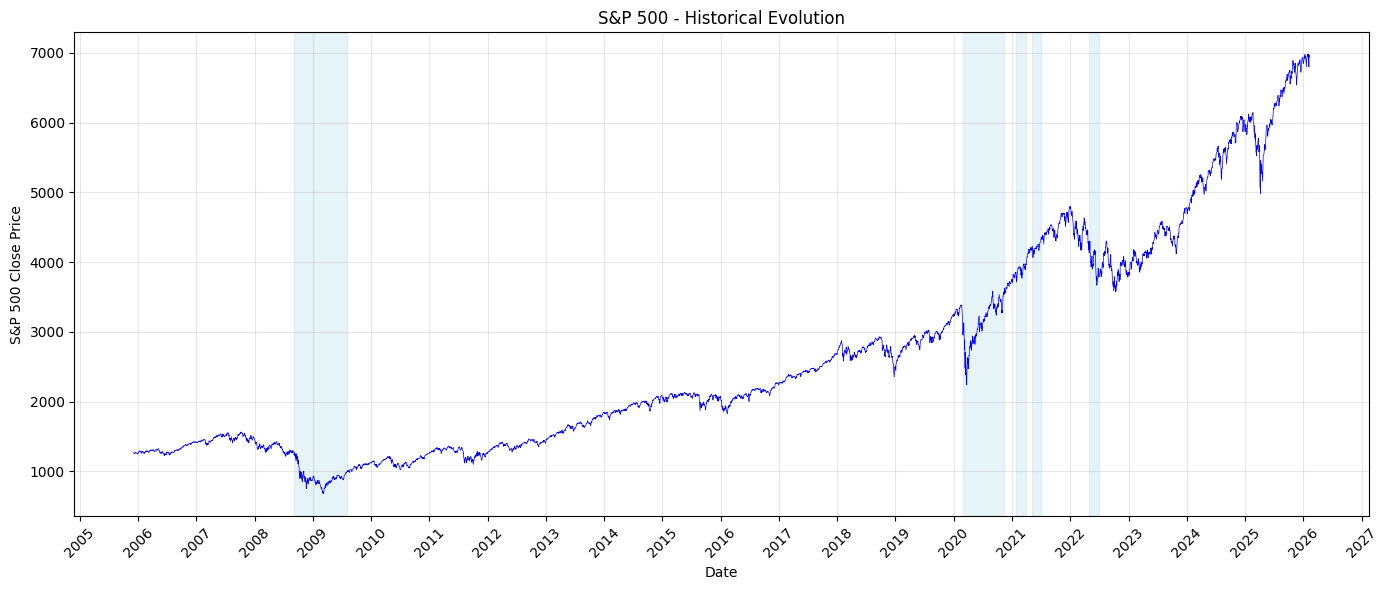

In [69]:
plt.figure(figsize=(14, 6))
plt.plot(sp500['date'], sp500['close'], linewidth=0.5, color='blue')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 - Historical Evolution')
plt.grid(True, alpha=0.3)

for start, end in crisis_periods:
    plt.axvspan(start, end, color='lightblue', alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))         
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))    

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Fase 2: Anatomía del Riesgo (Análisis Marginal)

Descargamos los valores de Yfinance


In [70]:
# Retornos diarios de la lista de symbols desde diciembre 2005 hasta hoy
df_symbols = yf.download(symbols, start='2006-01-01', end=end, auto_adjust=True)[["Close"]]

df_symbols = df_symbols.reset_index()
df_symbols = df_symbols.rename(columns={"Date": "date"})
df_symbols["date"] = pd.to_datetime(df_symbols["date"])

if isinstance(df_symbols.columns, pd.MultiIndex):
    new_cols = ["date"] + [col[1] for col in df_symbols.columns[1:]]
    df_symbols.columns = new_cols

df_symbols = df_symbols.sort_values("date").reset_index(drop=True)
df_returns_symbols = df_symbols.copy()
for s in symbols:
    df_returns_symbols[s] = df_symbols[s].pct_change()  
df_returns_symbols.head(5000)

[*********************100%***********************]  15 of 15 completed


,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-04,0.002943,-0.006936,-0.010621,0.000675,-0.002877,NaN,0.003389,0.035283,0.022999,0.015415,-0.005772,0.004843,0.027997,0.001872,0.001710
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012222,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000742,0.022650,-0.003227,-0.004951
3,2006-01-06,0.025813,0.004617,-0.001501,0.003378,0.018216,NaN,0.026366,0.032431,0.031956,0.004493,0.007045,-0.002964,0.016426,-0.001021,0.019732
4,2006-01-09,-0.003276,-0.016503,0.000645,0.003030,-0.005063,NaN,0.016381,-0.004933,0.002663,0.006230,0.016242,-0.001858,0.027914,0.007503,-0.000505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147,2022-06-24,0.024517,0.035752,0.007170,0.040221,0.016429,-0.011362,-0.000998,-0.047951,0.051077,0.014639,0.029846,0.034150,0.055532,0.014406,0.019834
4148,2022-06-27,0.000000,-0.027821,0.001238,0.000431,0.019341,0.039216,-0.001117,-0.040825,-0.018152,-0.000932,-0.008012,-0.010497,-0.015007,-0.007620,0.024511
4149,2022-06-28,-0.029790,-0.051404,-0.002782,-0.016308,0.016060,-0.075278,-0.001648,-0.040944,-0.033030,-0.028443,-0.004812,-0.031749,-0.052582,-0.016265,0.027743
4150,2022-06-29,0.013024,0.014153,-0.012399,-0.001351,-0.019741,-0.031524,-0.000766,-0.012221,-0.002732,0.000282,-0.004490,0.014738,-0.027531,0.009083,-0.036940


Agregamos al df bonos del gobierno y bonos high yield

In [71]:
df_aut_risk = (
df_returns_symbols
    .merge(dgs10[['date', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date', 'BAMLH0A0HYM2_change']], on='date', how='left')
)
df_auto = df_aut_risk[df_aut_risk['date'] >= '2006-01-01']
df_auto.head(500)

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-04,0.002943,-0.006936,-0.010621,0.000675,-0.002877,NaN,0.003389,0.035283,0.022999,0.015415,-0.005772,0.004843,0.027997,0.001872,0.001710,-0.01,-0.03,-0.04
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012222,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000742,0.022650,-0.003227,-0.004951,0.00,0.01,-0.05
3,2006-01-06,0.025813,0.004617,-0.001501,0.003378,0.018216,NaN,0.026366,0.032431,0.031956,0.004493,0.007045,-0.002964,0.016426,-0.001021,0.019732,0.02,0.04,-0.08
4,2006-01-09,-0.003276,-0.016503,0.000645,0.003030,-0.005063,NaN,0.016381,-0.004933,0.002663,0.006230,0.016242,-0.001858,0.027914,0.007503,-0.000505,0.00,0.00,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007-12-20,0.022335,0.013426,-0.004328,-0.008263,0.012651,NaN,-0.007193,0.018533,0.018188,0.000148,-0.014779,0.020983,0.020900,0.002878,0.007656,-0.02,-0.03,0.08
496,2007-12-21,0.035789,0.007507,0.012316,0.007656,0.021619,NaN,0.018177,-0.010467,0.010150,0.010397,0.018001,0.015203,-0.000284,0.012160,0.014111,0.14,0.10,-0.11
497,2007-12-24,0.025218,-0.002739,0.008588,0.014525,0.004679,NaN,0.000499,0.030106,0.005799,-0.002352,0.016323,0.014421,0.017634,-0.001890,0.002462,0.05,0.05,-0.03
498,2007-12-26,0.000754,0.020218,0.000473,0.006608,0.003810,NaN,0.017220,-0.006635,0.014428,-0.004567,0.002454,0.000820,0.013415,0.001352,0.012279,NaN,NaN,NaN


In [72]:
df_analysis = df_auto.merge(df_final[["date", "regime"]], on="date", how="left")
df_analysis.head(500)

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change,regime
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2006-01-04,0.002943,-0.006936,-0.010621,0.000675,-0.002877,NaN,0.003389,0.035283,0.022999,0.015415,-0.005772,0.004843,0.027997,0.001872,0.001710,-0.01,-0.03,-0.04,0
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012222,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000742,0.022650,-0.003227,-0.004951,0.00,0.01,-0.05,0
3,2006-01-06,0.025813,0.004617,-0.001501,0.003378,0.018216,NaN,0.026366,0.032431,0.031956,0.004493,0.007045,-0.002964,0.016426,-0.001021,0.019732,0.02,0.04,-0.08,0
4,2006-01-09,-0.003276,-0.016503,0.000645,0.003030,-0.005063,NaN,0.016381,-0.004933,0.002663,0.006230,0.016242,-0.001858,0.027914,0.007503,-0.000505,0.00,0.00,-0.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007-12-20,0.022335,0.013426,-0.004328,-0.008263,0.012651,NaN,-0.007193,0.018533,0.018188,0.000148,-0.014779,0.020983,0.020900,0.002878,0.007656,-0.02,-0.03,0.08,0
496,2007-12-21,0.035789,0.007507,0.012316,0.007656,0.021619,NaN,0.018177,-0.010467,0.010150,0.010397,0.018001,0.015203,-0.000284,0.012160,0.014111,0.14,0.10,-0.11,0
497,2007-12-24,0.025218,-0.002739,0.008588,0.014525,0.004679,NaN,0.000499,0.030106,0.005799,-0.002352,0.016323,0.014421,0.017634,-0.001890,0.002462,0.05,0.05,-0.03,0
498,2007-12-26,0.000754,0.020218,0.000473,0.006608,0.003810,NaN,0.017220,-0.006635,0.014428,-0.004567,0.002454,0.000820,0.013415,0.001352,0.012279,NaN,NaN,NaN,0


df_crisis_periods: Convierte los rangos de fechas definidos en crisis_periods que son tuplas start-end en un df día a día, donde cada fecha tiene su crisis_period. Esto permite etiquetar cada día individual con su número de crisis para luego calcular estadísticas separadas por evento 

In [73]:
crisis_rows = []

for i, (start, end) in enumerate(crisis_periods, start=1):
    mask = (df_final["date"] >= start) & (df_final["date"] <= end)
    dates_in_period = df_final.loc[mask, "date"]
    
    for d in dates_in_period:
        crisis_rows.append({"date": d, "crisis_period": i})

df_crisis_periods = pd.DataFrame(crisis_rows)
df_crisis_periods

,date,crisis_period
0,2008-09-02,1
1,2008-09-03,1
2,2008-09-04,1
3,2008-09-05,1
4,2008-09-08,1
...,...,...
544,2022-06-27,5
545,2022-06-28,5
546,2022-06-29,5
547,2022-06-30,5


calm_periods: Construye automáticamente los periodos de calma como los huecos entre crisis. El resultado es una lista de tuplas

In [74]:
calm_periods = []

# Calma antes de la primera crisis
calm_periods.append((
    df_analysis["date"].min(),
    crisis_periods[0][0]
))

# Calmas intermedias
for i in range(len(crisis_periods)-1):
    calm_periods.append((
        crisis_periods[i][1],
        crisis_periods[i+1][0]
    ))

# Calma después de la última crisis
calm_periods.append((
    crisis_periods[-1][1],
    df_analysis["date"].max()
))

df_periods: Etiqueta cada día del dataset con su period_type ("calm" o "crisis") y period_id. crea un Df completo donde no falta ningún día,luego hace un merge con df_analysis para tener retornos + etiquetas en una sola tabla

In [75]:
rows = []

# crisis
for i, (start, end) in enumerate(crisis_periods, start=1):
    mask = (df_analysis["date"] >= start) & (df_analysis["date"] <= end)
    for d in df_analysis.loc[mask, "date"]:
        rows.append({"date": d, "period_id": i, "period_type": "crisis"})

# calma
for i, (start, end) in enumerate(calm_periods, start=1):
    mask = (df_analysis["date"] >= start) & (df_analysis["date"] <= end)
    for d in df_analysis.loc[mask, "date"]:
        rows.append({"date": d, "period_id": i, "period_type": "calm"})

df_periods = pd.DataFrame(rows)


ordena el df por fecha y se agrupan los periodos

In [76]:
df_analysis_periods = df_analysis.merge(df_periods, on="date", how="left")

In [77]:
period_info = []

# crisis
for i, (start, end) in enumerate(crisis_periods, start=1):
    period_info.append({"period_type": "crisis", "period_id": i, "start_date": start})

# calma
for i, (start, end) in enumerate(calm_periods, start=1):
    period_info.append({"period_type": "calm", "period_id": i, "start_date": start})

df_period_info = pd.DataFrame(period_info)


In [78]:
stats_by_period = (
    df_analysis_periods
    .drop(columns=["date", "regime"])
    .groupby(["period_type", "period_id"])
    .agg([
        ("mean", "mean"),
        ("std", "std"),
        ("skew", pd.Series.skew),
        ("kurtosis", pd.Series.kurtosis)
    ])
)

stats_by_period = stats_by_period.reset_index()
stats_by_period.columns = [
    "_".join(col).strip("_") if isinstance(col, tuple) else col
    for col in stats_by_period.columns
]
stats_by_period = stats_by_period.rename(columns={"date_min": "start_date"}) #Renombramos la columna
stats_by_period = stats_by_period.merge(df_period_info, on=["period_type", "period_id"], how="left")
stats_by_period = stats_by_period.sort_values("start_date").reset_index(drop=True)

cols = stats_by_period.columns.tolist()
fixed = ["period_type", "period_id", "start_date"]
others = [c for c in cols if c not in fixed]
stats_by_period = stats_by_period[fixed + others]

stats_by_period


,period_type,period_id,start_date,AAPL_mean,AAPL_std,AAPL_skew,AAPL_kurtosis,AMZN_mean,AMZN_std,AMZN_skew,...,DGS10_change_skew,DGS10_change_kurtosis,DGS2_change_mean,DGS2_change_std,DGS2_change_skew,DGS2_change_kurtosis,BAMLH0A0HYM2_change_mean,BAMLH0A0HYM2_change_std,BAMLH0A0HYM2_change_skew,BAMLH0A0HYM2_change_kurtosis
0,calm,1,2006-01-03,0.001501,0.024861,0.151923,1.799327,0.001235,0.029795,1.558274,...,-0.004476,0.734763,-0.004128,0.066478,0.125984,2.108490,0.006983,0.077963,0.578033,3.445957
1,crisis,1,2008-09-02,0.000563,0.036414,-0.154715,3.186776,0.001185,0.043334,0.344174,...,-0.613661,2.191724,-0.004773,0.087567,-0.346054,7.636689,0.004783,0.282595,0.521780,3.902799
2,calm,2,2009-08-04,0.001105,0.016294,-0.201664,4.210817,0.001356,0.020188,1.252930,...,0.066770,0.962046,-0.000004,0.030808,-0.294915,2.138813,-0.001903,0.081540,0.774682,4.662124
3,crisis,2,2020-02-27,0.003137,0.032936,-0.068894,2.912478,0.002739,0.027016,-0.022439,...,0.038715,5.266061,-0.005747,0.036403,-2.076769,14.117299,0.002458,0.245365,1.061034,5.522618
4,calm,3,2020-11-10,0.003940,0.018216,0.332731,-0.109070,0.000638,0.015176,0.428150,...,0.390378,0.075440,-0.000213,0.013431,-0.297108,-0.221578,-0.005294,0.070181,1.157904,2.998591
5,crisis,3,2021-01-27,-0.003066,0.020033,0.400779,0.670026,-0.000969,0.016750,0.168260,...,0.577763,2.414590,0.000889,0.013952,0.990829,3.176333,-0.010870,0.050369,0.377405,0.086125
6,calm,4,2021-04-01,0.003801,0.013277,-0.001416,-1.158263,0.004198,0.013300,-0.545675,...,-0.623624,-0.187857,-0.000909,0.011916,0.190357,-0.249884,-0.000476,0.040184,0.927590,1.184553
7,crisis,4,2021-05-03,0.001129,0.013035,-0.574916,0.454256,-0.000152,0.012825,-0.316440,...,0.036084,-1.004430,0.001667,0.017379,0.345862,0.249728,-0.007209,0.030809,1.107806,2.251186
8,calm,5,2021-07-01,0.000804,0.016161,0.250414,0.858528,-0.000777,0.021981,0.786481,...,0.131313,0.271709,0.011173,0.050262,1.173343,4.178400,0.004000,0.084949,0.126955,2.097615
9,crisis,5,2022-04-26,-0.003375,0.028198,-0.184741,-0.960748,-0.006098,0.039984,-0.851897,...,0.634921,1.217704,0.004318,0.099286,0.540579,2.906043,0.044130,0.156923,0.062664,0.146984


¿Sigue siendo el Oro (GLD) un activo refugio?
Mira:
- si la media sube o se mantiene en crisis
- si la volatilidad no aumenta demasiado
- si el skew se vuelve positivo
- si la kurtosis no explota
Interpretación típica:
- GLD mantiene media positiva en crisis
- volatilidad sube moderadamente
- skew positivo
- kurtosis moderada
Si tus datos muestran eso, entonces sí, sigue siendo refugio.


In [79]:
subset_gld = stats_by_period[
    [
        "period_type",
        "period_id",
        "start_date",
        "GLD_mean",
        "GLD_std",
        "GLD_skew",
        "GLD_kurtosis"
    ]
]

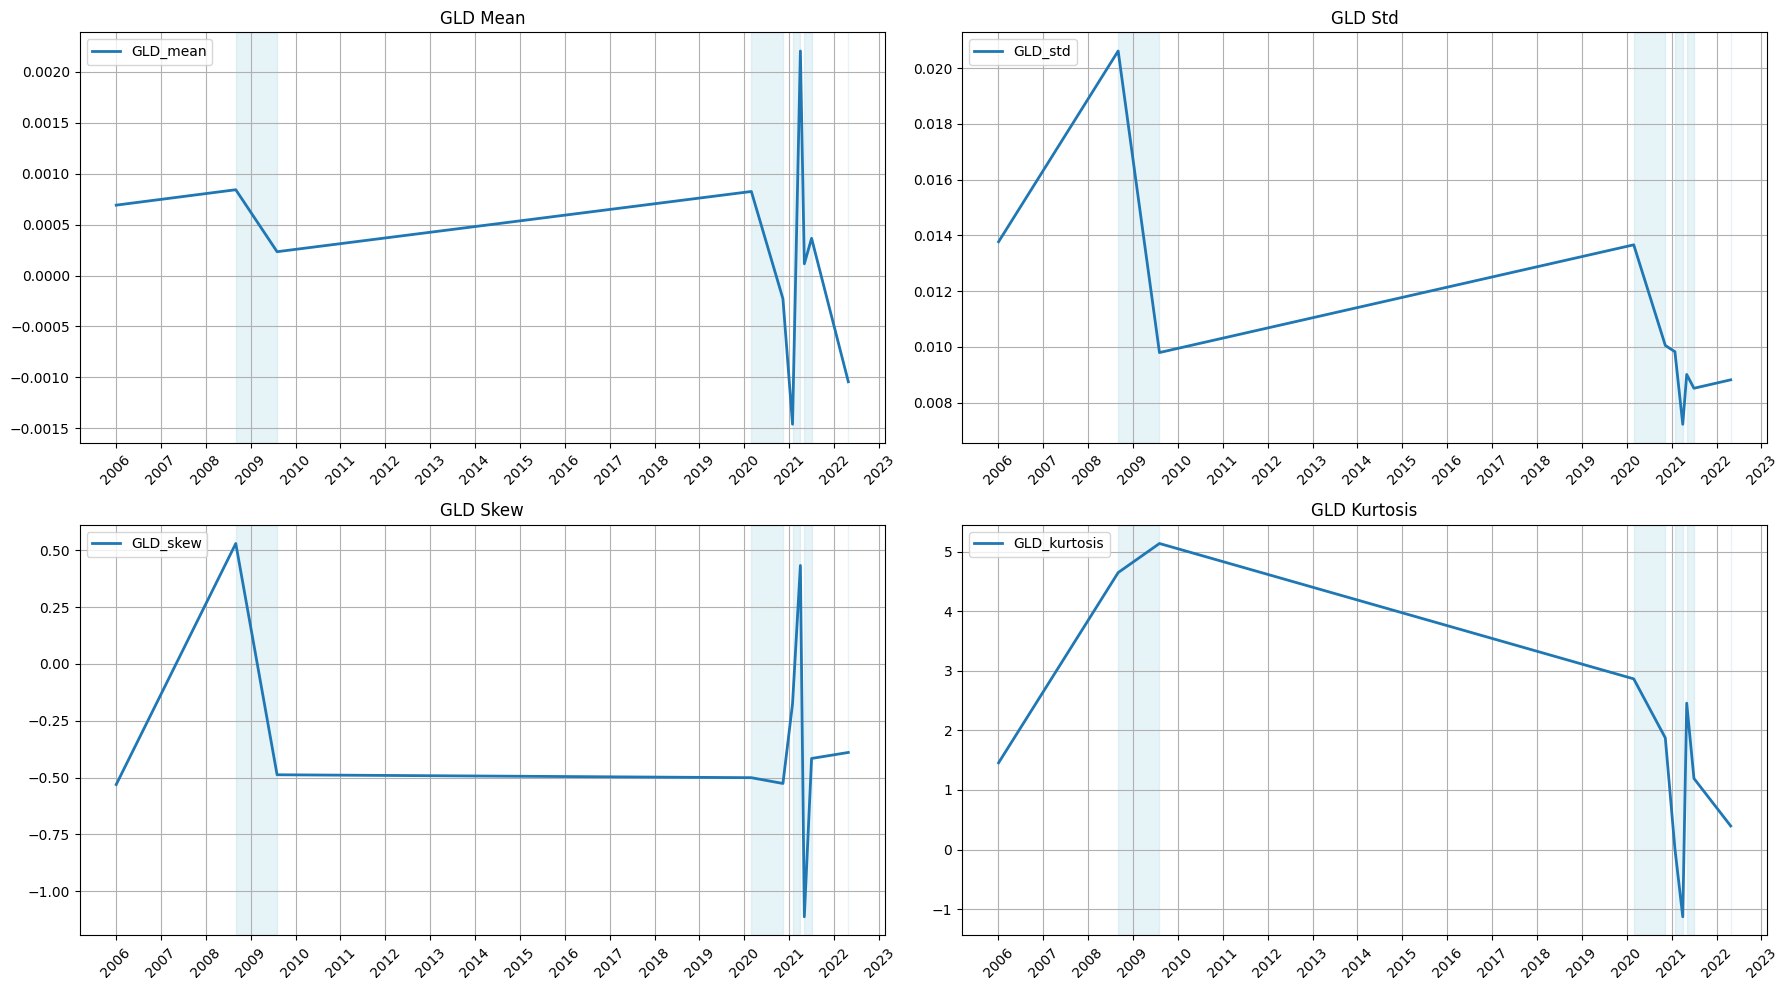

In [80]:
df_plot = stats_by_period.copy()
df_plot["start_date"] = pd.to_datetime(df_plot["start_date"])

# Métricas a graficar
metrics = ["GLD_mean", "GLD_std", "GLD_skew", "GLD_kurtosis"]
titles = ["GLD Mean", "GLD Std", "GLD Skew", "GLD Kurtosis"]

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for ax, metric, title in zip(axes, metrics, titles):

    # Línea principal
    ax.plot(df_plot["start_date"], df_plot[metric], label=metric, linewidth=2)

    # Franjas azules para crisis
    for i, row in df_plot[df_plot["period_type"] == "crisis"].iterrows():
        start = row["start_date"]
        # siguiente periodo o final
        end = df_plot.loc[i + 1, "start_date"] if i + 1 < len(df_plot) else df_plot["start_date"].max()
        ax.axvspan(start, end, color="lightblue", alpha=0.3)

    # Formato del eje X: todos los años
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis='x', rotation=45)

    ax.set_title(title)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



Explicación de las gráficas:

El oro muestra un comportamiento condicional como activo refugio. Durante crisis de pánico financiero (2008) y de liquidez (COVID-2020), cumple los criterios: retornos positivos, skew favorable y protección de capital. Sin embargo, en la crisis de estanflación de 2022, el oro falló dramáticamente: retornos negativos (-0.15% diario), skew negativo y pérdida de su función protectora.
La volatilidad tampoco es consistente: se duplica en crisis financieras profundas (2008) pero se mantiene controlada en shocks rápidos (COVID). La kurtosis elevada en 2008 indica eventos extremos impredecibles.
Conclusión: El oro funciona como refugio en crisis de miedo/pánico, pero NO en crisis inflacionarias con subidas de tipos de interés. No es un refugio universal y su efectividad depende del régimen macroeconómico subyacente.

### Fase 3: Cuando la Diversificación Falla (Cópulas)

* Probar que las correlaciones tienen a 1

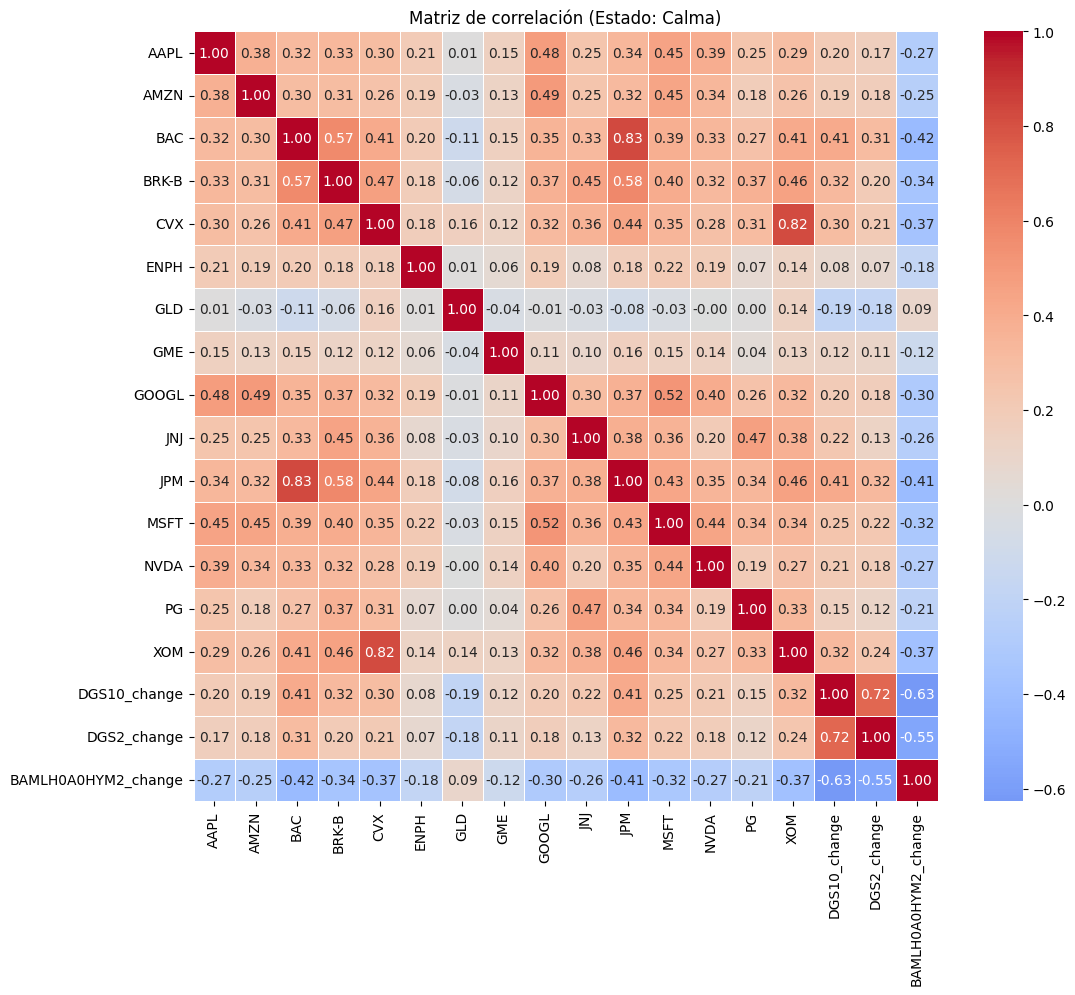

In [244]:
#Calcular matriz de correlación de Pearson en Estado "Calma".

df_calm = df_analysis_periods[df_analysis_periods["period_type"] == "calm"]
df_calm_clean = df_calm.dropna()


numeric_cols = [
    c for c in df_calm.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]
df_calm_numeric = df_calm[numeric_cols]

corr_calm = df_calm_numeric.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_calm, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación (Estado: Calma)")
plt.show()


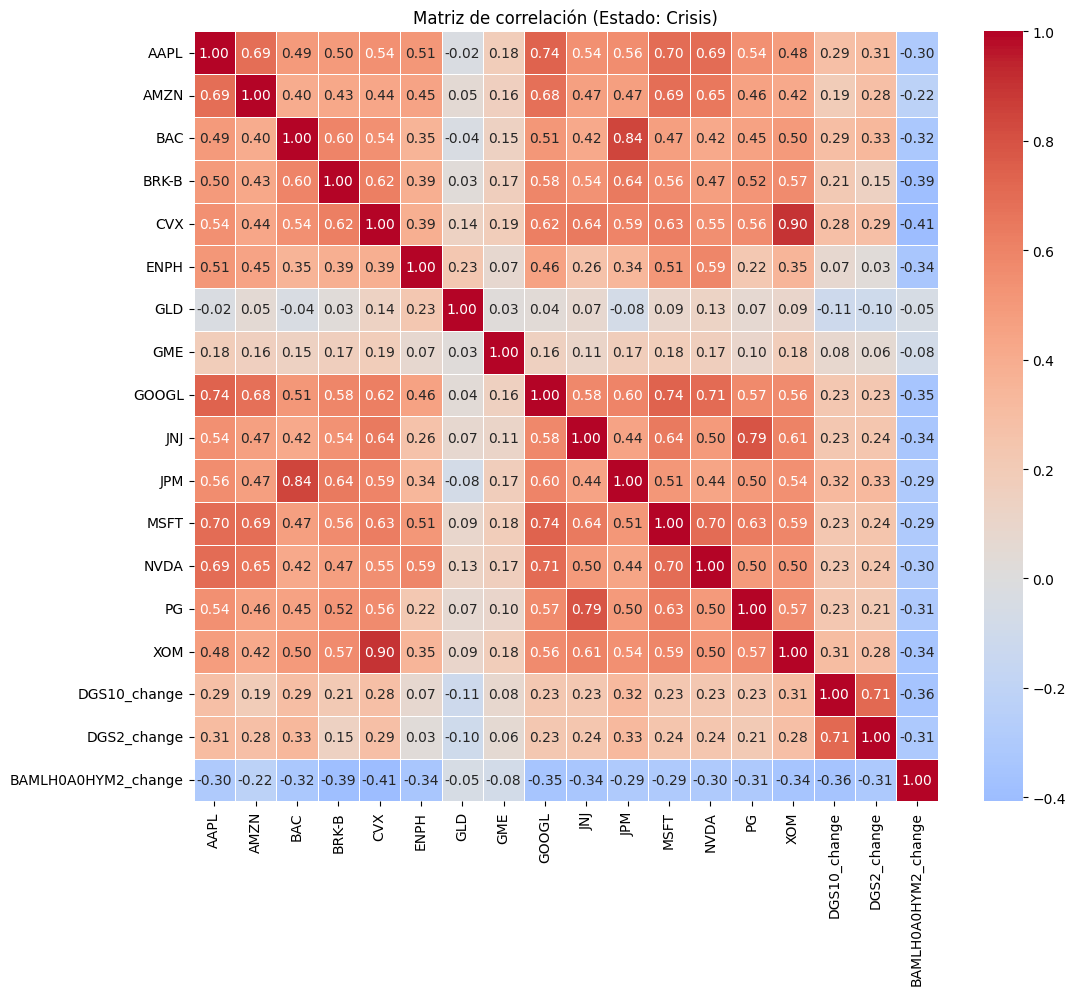

In [245]:
#Calcular matriz de correlación en Estado "Estrés". 

df_crisis = df_analysis_periods[df_analysis_periods["period_type"] == "crisis"]
df_crisis_clean = df_crisis.dropna()


numeric_cols = [
    c for c in df_crisis.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]
df_crisis_numeric = df_crisis[numeric_cols]

corr_crisis = df_crisis_numeric.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_crisis, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación (Estado: Crisis)")
plt.show()

Se ve claramente que en periodos de crisis todo tiende a la correelación. 

Se usan las copulas gausianas para periodos de calma y las t-copulas son las más apropiadas para la gestión de riesgos.
Las cópulas no trabajan con retornos directamente, sino con variables transformadas a uniformes. Esta transformación se llama pseudo‑observaciones.


**Pseudo-observaciones**: Transforman cada retorno en su **percentil relativo** dentro de su propia historia usando **rankdata(x)/(len(x)+1)**. Esto convierte valores absolutos en posiciones ordinales (ej: -5% de AAPL → "percentil 9% = muy malo", 0.2% de GLD → "percentil 68% = bueno"), igualando todas las escalas a [0,1] uniforme y eliminando diferencias de volatilidad entre activos, pero **conservando intacta la dependencia** (si AAPL y AMZN subían juntos antes, sus percentiles también subirán juntos después). Permite comparar "días buenos vs malos" entre activos con escalas completamente diferentes.

In [246]:
#Ajustar las cópulas en ambos estados.

# Días de calma
df_calm = df_analysis_periods[df_analysis_periods["period_type"] == "calm"]

# Rretornos
numeric_cols = [
    c for c in df_calm.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]

df_calm_numeric = df_calm[numeric_cols].dropna()

# Convertir retornos a pseudo‑observaciones U(0,1)
U_calm = df_calm_numeric.apply(
    lambda x: rankdata(x) / (len(x) + 1), # rankdata Toma una columna de retornos y reemplaza cada valor por su posición ordenada.
                                          # rankdata(x) / (len(x) + 1) Divide cada rango entre el número total de observaciones + 1.          
    axis=0
)                                         #U_calm - Df con cada columna es ahora una variable uniforme U(0,1), la dependencia entre columnas se mantiene
                                          # La forma marginal (la distribución de cada activo) desaparece                      

# Ajustar la cópula gaussiana
copula_calm = GaussianMultivariate()
copula_calm.fit(U_calm)
corr_calm_copula = copula_calm.correlation

mat corr con cop.gausiana

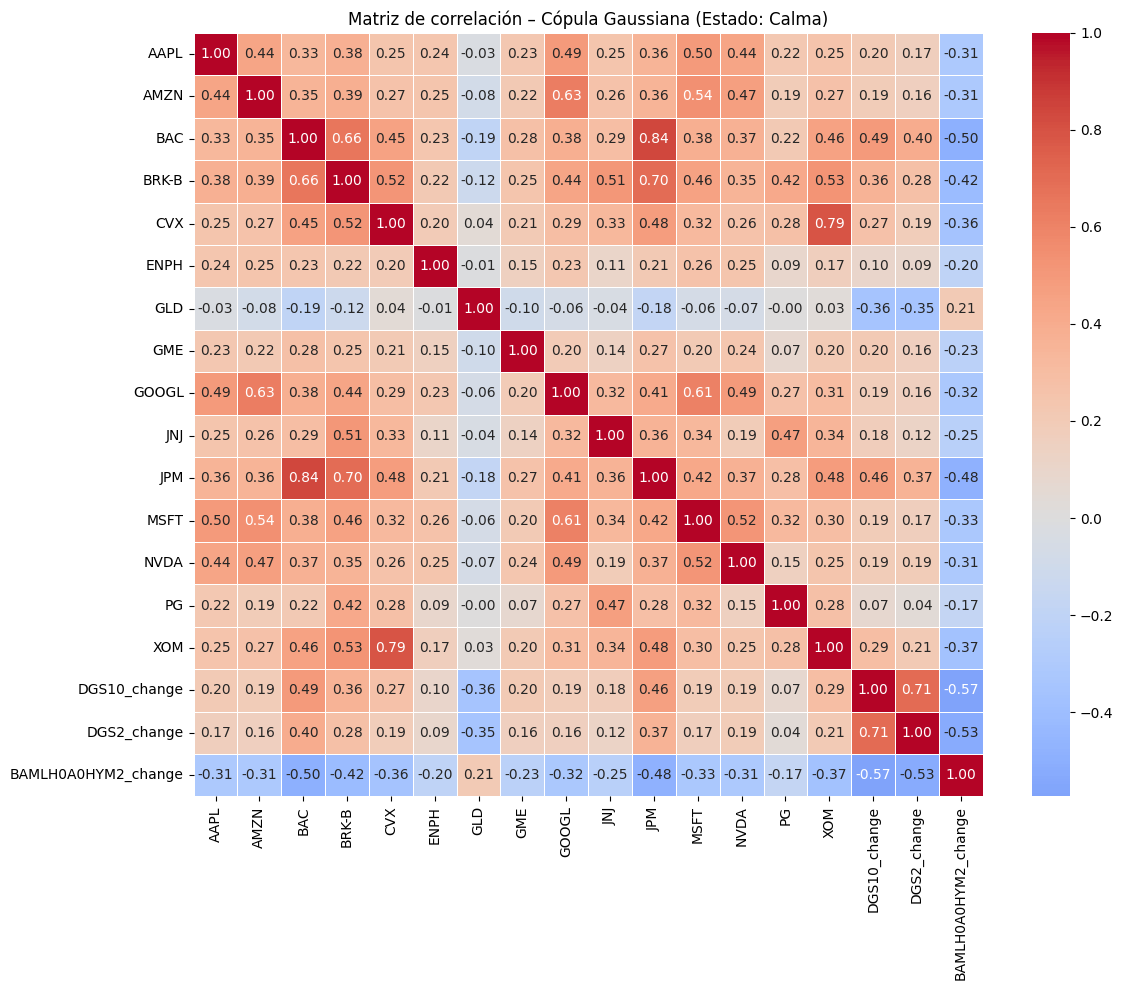

In [247]:
corr_matrix = np.array(corr_calm_copula)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    xticklabels=numeric_cols,
    yticklabels=numeric_cols,
    linewidths=0.5
)
plt.title("Matriz de correlación – Cópula Gaussiana (Estado: Calma)")
plt.tight_layout()
plt.show()


In [248]:
#Datos sintéticos generados por la cópula
synthetic_calm = copula_calm.sample(len(df_calm_numeric))

# 3 columnas
cols = numeric_cols[:3]   # o elige manualmente 3 columnas

# Comparación 3D
compare_3d(df_calm_numeric, synthetic_calm, columns=cols,
           title="Comparación 3D: Datos Reales vs Cópula Gaussiana (Calma)")


cambio: hacemos los puntos más pequeños para comprobar que los puntos generados por la copula son similares a los datos reales


In [249]:

# 3 columnas
cols = numeric_cols[:3]

# Gráfico 3D personalizado
fig = go.Figure()

# Puntos reales (USAR U_calm en vez de df_calm_numeric)
fig.add_trace(go.Scatter3d(
    x=U_calm[cols[0]],  
    y=U_calm[cols[1]],  
    z=U_calm[cols[2]],  
    mode='markers',
    name='Real',
    marker=dict(size=1, color='darkblue', opacity=0.6)
))

# Puntos sintéticos
fig.add_trace(go.Scatter3d(
    x=synthetic_calm[cols[0]],
    y=synthetic_calm[cols[1]],
    z=synthetic_calm[cols[2]],
    mode='markers',
    name='Synthetic',
    marker=dict(size=1, color='orange', opacity=0.4)
))

fig.update_layout(
    title="Comparación 3D: Pseudo-observaciones Reales vs Sintéticas (Calma)",
    scene=dict(xaxis_title=cols[0], yaxis_title=cols[1], zaxis_title=cols[2]),
    width=900, height=700
)

fig.show()

In [250]:
#Ajustar las cópulas en ambos estados. CRISIS


# Dias crisis
df_crisis = df_analysis_periods[df_analysis_periods["period_type"] == "crisis"]

# Retornos
numeric_cols = [
    c for c in df_crisis.select_dtypes(include="number").columns
    if c not in ["regime", "period_id"]
]

df_crisis_numeric = df_crisis[numeric_cols].dropna()

# 3. Convertir retornos a pseudo‑observaciones U(0,1)
U_crisis = df_crisis_numeric.apply(
    lambda x: rankdata(x) / (len(x) + 1),
    axis=0
)

# 4. Ajustar la t‑cópula
copula_crisis = TCopula()
copula_crisis.fit(U_crisis)

# 5. Obtener la matriz de correlación de la cópula
# En algunas versiones, la matriz está en copula_crisis.correlation
corr_copula_crisis = copula_crisis.correlation

corr_copula_crisis

,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change
AAPL,1.000000,0.717417,0.498563,0.590221,0.416057,0.479292,0.198155,0.226286,0.764029,0.479707,0.489579,0.839401,0.773502,0.565988,0.396347,0.201987,0.069935,-0.436020
AMZN,0.717417,1.000000,0.281689,0.387280,0.195902,0.456663,0.189721,0.170538,0.705233,0.344298,0.265282,0.745231,0.692697,0.418521,0.198574,0.023473,-0.048849,-0.317764
BAC,0.498563,0.281689,1.000000,0.810953,0.705796,0.303534,0.049872,0.246619,0.545685,0.448272,0.949085,0.498101,0.407820,0.486131,0.702772,0.451847,0.202860,-0.551077
BRK-B,0.590221,0.387280,0.810953,1.000000,0.709467,0.310455,0.099718,0.247750,0.617501,0.612056,0.828941,0.586616,0.490117,0.640414,0.679763,0.304716,0.142235,-0.545934
CVX,0.416057,0.195902,0.705796,0.709467,1.000000,0.315418,0.157498,0.189318,0.499370,0.467034,0.718549,0.439586,0.407734,0.382533,0.881766,0.291400,0.116286,-0.443315
ENPH,0.479292,0.456663,0.303534,0.310455,0.315418,1.000000,0.228066,0.181241,0.417728,0.196766,0.286404,0.474218,0.581744,0.196146,0.325239,0.095077,0.051247,-0.300148
GLD,0.198155,0.189721,0.049872,0.099718,0.157498,0.228066,1.000000,0.073546,0.173758,0.139495,0.041461,0.189027,0.262771,0.173899,0.087736,-0.185821,-0.164683,-0.051434
GME,0.226286,0.170538,0.246619,0.247750,0.189318,0.181241,0.073546,1.000000,0.170659,0.043802,0.241213,0.188725,0.196795,0.075146,0.192337,0.103217,0.007958,-0.152038
GOOGL,0.764029,0.705233,0.545685,0.617501,0.499370,0.417728,0.173758,0.170659,1.000000,0.499428,0.537316,0.845153,0.752968,0.554054,0.458787,0.212748,0.057225,-0.484994
JNJ,0.479707,0.344298,0.448272,0.612056,0.467034,0.196766,0.139495,0.043802,0.499428,1.000000,0.473308,0.534964,0.391357,0.691307,0.396330,0.181946,0.064328,-0.370313


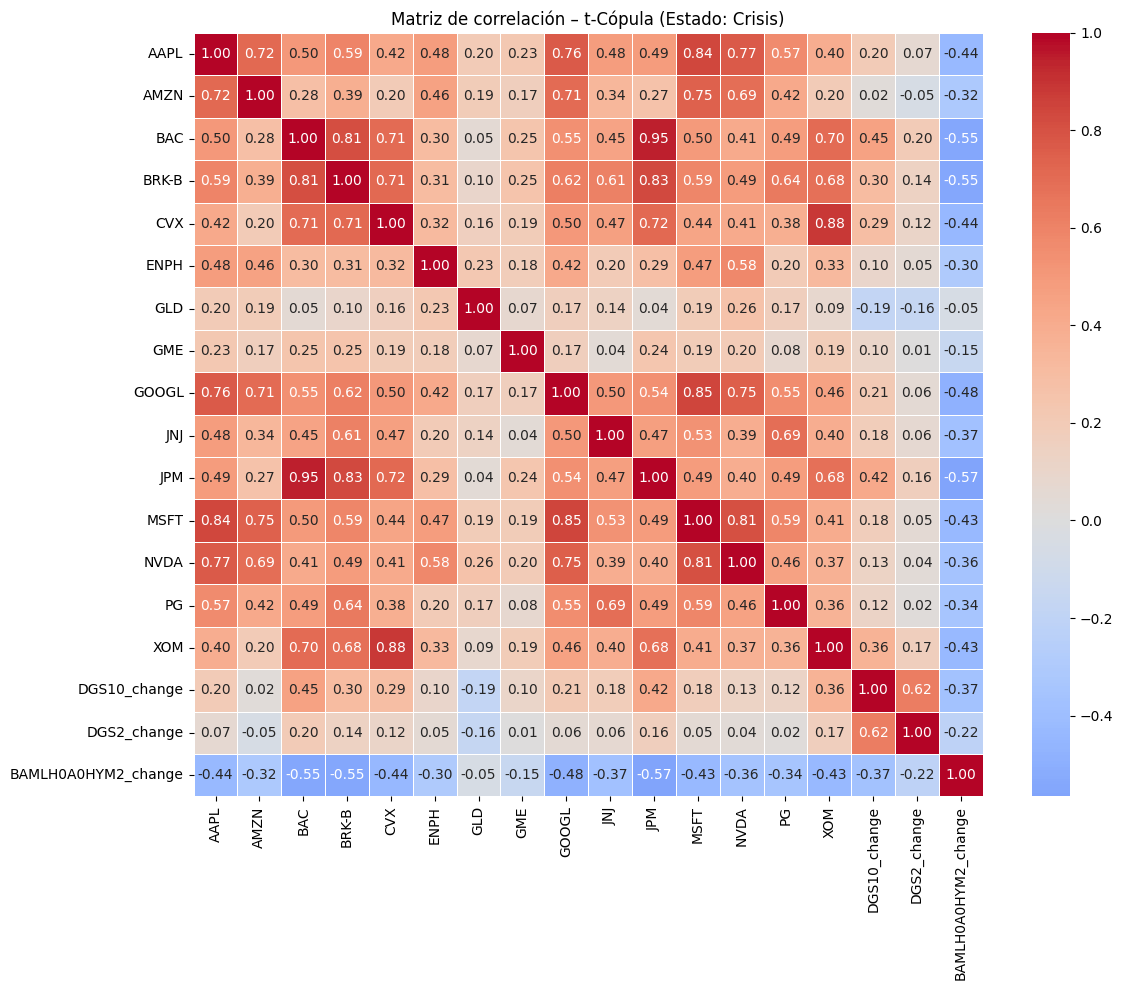

In [251]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_copula_crisis,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    xticklabels=numeric_cols,
    yticklabels=numeric_cols,
    linewidths=0.5
)
plt.title("Matriz de correlación – t‑Cópula (Estado: Crisis)")
plt.tight_layout()
plt.show()


Comparamos las 4 matrices obtenidas

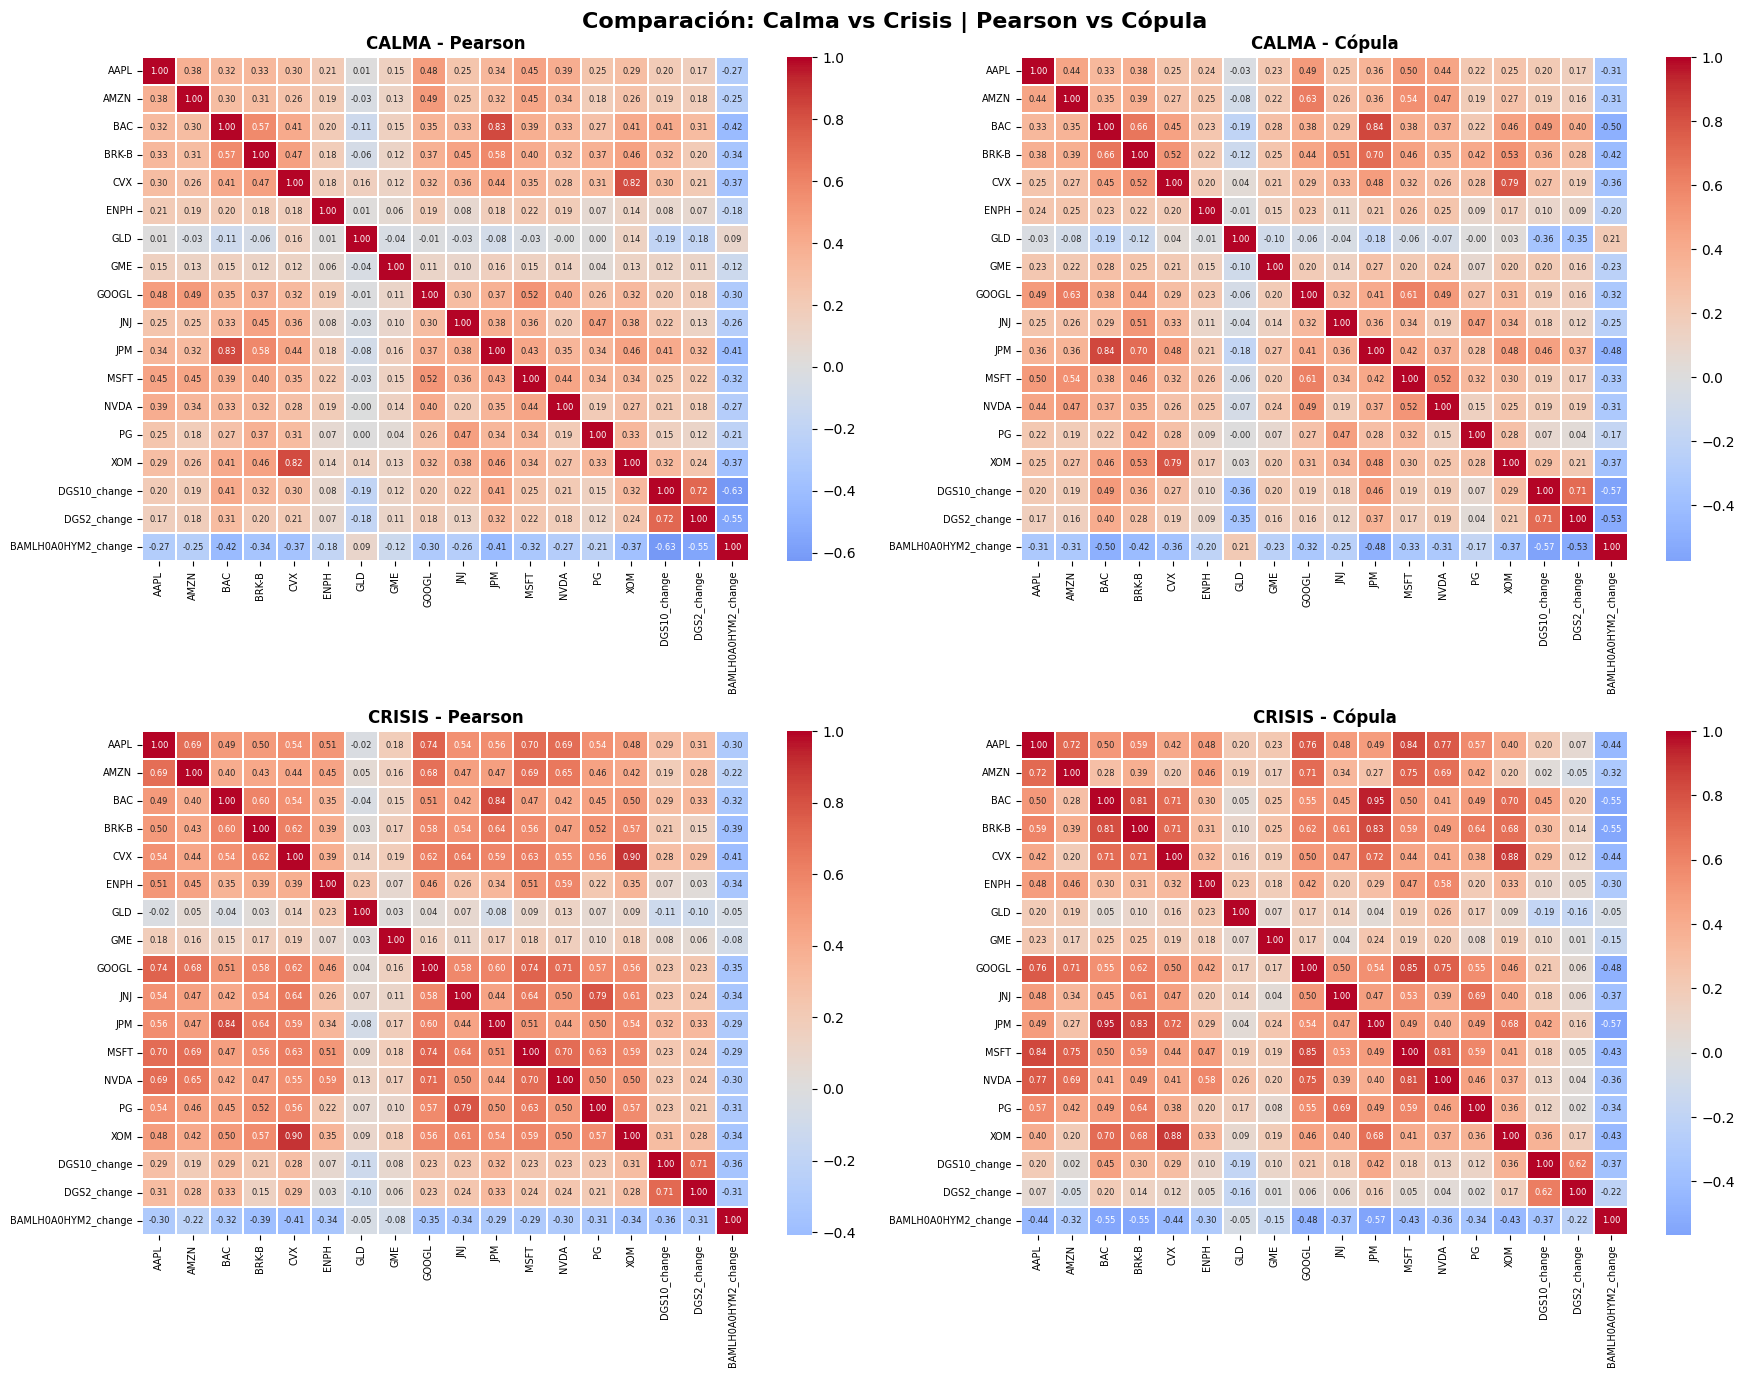

In [252]:

# Crear figura con 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Panel 1: Calma - Pearson
sns.heatmap(corr_calm, cmap="coolwarm", center=0, annot=True, fmt=".2f", 
            linewidths=0.3, ax=axes[0, 0], annot_kws={'fontsize': 6})
axes[0, 0].set_title("CALMA - Pearson", fontsize=12, fontweight='bold')
axes[0, 0].tick_params(labelsize=7)

# Panel 2: Calma - Cópula
sns.heatmap(np.array(corr_calm_copula), cmap="coolwarm", center=0, annot=True, fmt=".2f",
            xticklabels=numeric_cols, yticklabels=numeric_cols, linewidths=0.3, 
            ax=axes[0, 1], annot_kws={'fontsize': 6})
axes[0, 1].set_title("CALMA - Cópula", fontsize=12, fontweight='bold')
axes[0, 1].tick_params(labelsize=7)

# Panel 3: Crisis - Pearson
sns.heatmap(corr_crisis, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            linewidths=0.3, ax=axes[1, 0], annot_kws={'fontsize': 6})
axes[1, 0].set_title("CRISIS - Pearson", fontsize=12, fontweight='bold')
axes[1, 0].tick_params(labelsize=7)

# Panel 4: Crisis - Cópula
sns.heatmap(np.array(corr_copula_crisis), cmap="coolwarm", center=0, annot=True, fmt=".2f",
            xticklabels=numeric_cols, yticklabels=numeric_cols, linewidths=0.3,
            ax=axes[1, 1], annot_kws={'fontsize': 6})
axes[1, 1].set_title("CRISIS - Cópula", fontsize=12, fontweight='bold')
axes[1, 1].tick_params(labelsize=7)

plt.suptitle('Comparación: Calma vs Crisis | Pearson vs Cópula', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**FASE 4**: Motor de simulación

Vamos a hacer una simulacción Monte Carlo con datos sintéticos

In [253]:
# Parámetros del simulador
N_SIMULACIONES = 20 #El enunciado pide 10 000 pero en mi ordenador se tira la vida.  
HORIZONTE_DIAS = 126  # igual, pide 126
SEED = 42               

np.random.seed(SEED)

Tomamos la matriz de probabilidad de que transicione de un estado de calma a un estado de alarma y viceversa.

In [254]:
# Matriz de transición del HMM (de Fase 1)
transition_matrix = model.transmat_

# Mostrar probabilidades de transición
print("Matriz de transición")
print(transition_matrix)
print(f"\nProbabilidad(Calma → Crisis) = {transition_matrix[0, 1]:.3f}")
print(f"Probabilidad(Crisis → Calma) = {transition_matrix[1, 0]:.3f}")

Matriz de transición
[[0.98666513 0.01333487]
 [0.07633692 0.92366308]]

Probabilidad(Calma → Crisis) = 0.013
Probabilidad(Crisis → Calma) = 0.076


**Parámetros por régimen**: Para cada activo, calcula el promedio de medias (mean) y promedio de volatilidades (std) a lo largo de todos sus periodos de calma y todos sus periodos de crisis, guardándolos en diccionarios params_calma y params_crisis. Estos diccionarios contienen las distribuciones marginales (individuales) que se usarán en el simulador: en calma AAPL tiene media +0.08% y std 1.36%, mientras en crisis tiene media -0.28% y std 3.65% (más volátil y negativa).

In [255]:
# Extraer estadísticas por régimen (promediar sobre todos los periodos)
stats_calma = stats_by_period[stats_by_period['period_type'] == 'calm']
stats_crisis = stats_by_period[stats_by_period['period_type'] == 'crisis']

# Crear diccionarios con parámetros para el simulador
params_calma = {}
params_crisis = {}

for activo in numeric_cols:
    params_calma[activo] = {
        'mean': stats_calma[f'{activo}_mean'].mean(),
        'std': stats_calma[f'{activo}_std'].mean()
    }
    
    params_crisis[activo] = {
        'mean': stats_crisis[f'{activo}_mean'].mean(),
        'std': stats_crisis[f'{activo}_std'].mean()
    }

Simulación Monte Carlo

In [256]:
from scipy.stats import norm

def simular_trayectorias(n_sim, horizonte, transition_matrix, 
                         params_calma, params_crisis,
                         copula_calma, copula_crisis, 
                         activos, estado_inicial=0):
    
    n_activos = len(activos)
    retornos_sim = np.zeros((n_sim, horizonte, n_activos))
    estados_sim = np.zeros((n_sim, horizonte), dtype=int)
    
    for sim in range(n_sim):
        estado = estado_inicial
        
        for t in range(horizonte):
            estados_sim[sim, t] = estado
            
            # Simular retornos según estado
            if estado == 0:
                U = copula_calm.sample(1).values[0]
                params = params_calma
            else:
                U = copula_crisis.sample(1).values[0]
                params = params_crisis
            
            # Transformar uniformes a retornos (con protección contra extremos)
            for i, activo in enumerate(activos):
                U_safe = np.clip(U[i], 1e-8, 1 - 1e-8)  # Evitar 0 y 1 exactos
                z = norm.ppf(U_safe)
                
                # Protección adicional contra valores extremos de z
                z = np.clip(z, -10, 10)  # Limitar a ±10 desviaciones estándar
                
                ret = params[activo]['mean'] + params[activo]['std'] * z
                retornos_sim[sim, t, i] = ret
            
            # Transición de estado
            prob_transicion = transition_matrix[estado]
            estado = np.random.choice([0, 1], p=prob_transicion)
    
    return {
        'retornos': retornos_sim,
        'estados': estados_sim
    }

In [257]:
print("Ejecutando simulación Monte Carlo...")

resultados = simular_trayectorias(
    N_SIMULACIONES, HORIZONTE_DIAS,
    transition_matrix, params_calma, params_crisis,
    copula_calm, copula_crisis, numeric_cols
)

print(f"✓ Generadas {N_SIMULACIONES:,} trayectorias de {HORIZONTE_DIAS} días")

Ejecutando simulación Monte Carlo...
✓ Generadas 20 trayectorias de 126 días


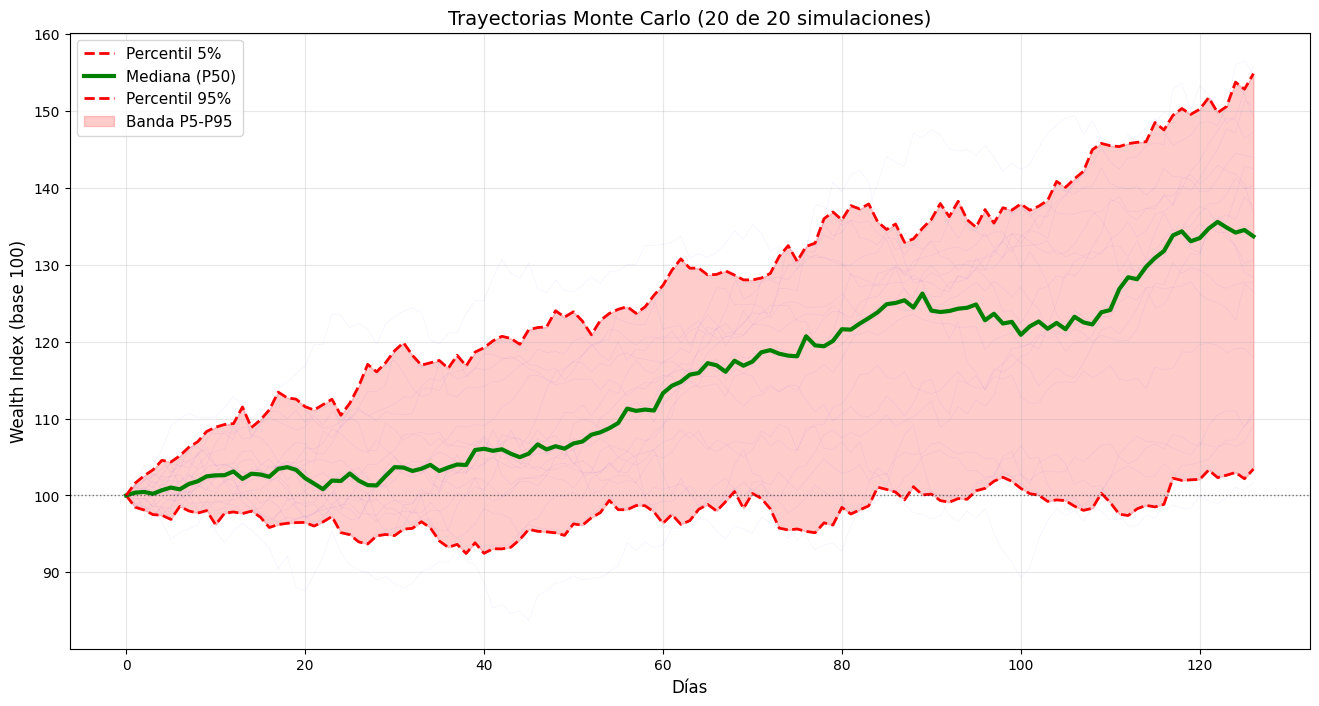


Wealth final (día 126):
  Mínimo (peor caso):     101.71
  Percentil 5%:           103.43
  Mediana:                133.70
  Percentil 95%:          154.86
  Máximo (mejor caso):    155.95
  Probabilidad pérdida:   0.0%


In [258]:
# Seleccionar una muestra de trayectorias para visualizar
n_trayectorias_mostrar = 20

plt.figure(figsize=(16, 8))

# Graficar trayectorias individuales (muestra)
for sim in range(n_trayectorias_mostrar):
    plt.plot(wealth_simulado[sim], color='blue', alpha=0.05, linewidth=0.5)

# Percentiles principales
plt.plot(p5, 'r--', linewidth=2, label='Percentil 5%')
plt.plot(p50, 'g-', linewidth=3, label='Mediana (P50)')
plt.plot(p95, 'r--', linewidth=2, label='Percentil 95%')

# Zona de confianza
plt.fill_between(range(len(p5)), p5, p95, alpha=0.2, color='red', label='Banda P5-P95')

plt.xlabel('Días', fontsize=12)
plt.ylabel('Wealth Index (base 100)', fontsize=12)
plt.title(f'Trayectorias Monte Carlo ({n_trayectorias_mostrar} de {N_SIMULACIONES:,} simulaciones)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=100, color='black', linestyle=':', linewidth=1, alpha=0.5)
plt.show()

# Estadísticas finales
wealth_final = wealth_simulado[:, -1]
print(f"\nWealth final (día {HORIZONTE_DIAS}):")
print(f"  Mínimo (peor caso):     {wealth_final.min():.2f}")
print(f"  Percentil 5%:           {np.percentile(wealth_final, 5):.2f}")
print(f"  Mediana:                {np.percentile(wealth_final, 50):.2f}")
print(f"  Percentil 95%:          {np.percentile(wealth_final, 95):.2f}")
print(f"  Máximo (mejor caso):    {wealth_final.max():.2f}")
print(f"  Probabilidad pérdida:   {(wealth_final < 100).mean():.1%}")

Cartera equiponderada histórica


In [259]:
# Cartera equiponderada
n_activos = len(numeric_cols)
pesos = np.ones(n_activos) / n_activos

# Retornos históricos de la cartera
retornos_cartera_real = (df_analysis_periods[numeric_cols].dropna() * pesos).sum(axis=1)

# Wealth index histórico
wealth_real = (1 + retornos_cartera_real).cumprod() * 100

In [260]:
# Calcular wealth para cada trayectoria
wealth_simulado = np.zeros((N_SIMULACIONES, HORIZONTE_DIAS + 1))
wealth_simulado[:, 0] = 100

for sim in range(N_SIMULACIONES):
    retornos_cartera_sim = (resultados['retornos'][sim] * pesos).sum(axis=1)
    wealth_simulado[sim, 1:] = 100 * (1 + retornos_cartera_sim).cumprod()

# Percentiles
p5 = np.percentile(wealth_simulado, 5, axis=0)
p50 = np.percentile(wealth_simulado, 50, axis=0)
p95 = np.percentile(wealth_simulado, 95, axis=0)

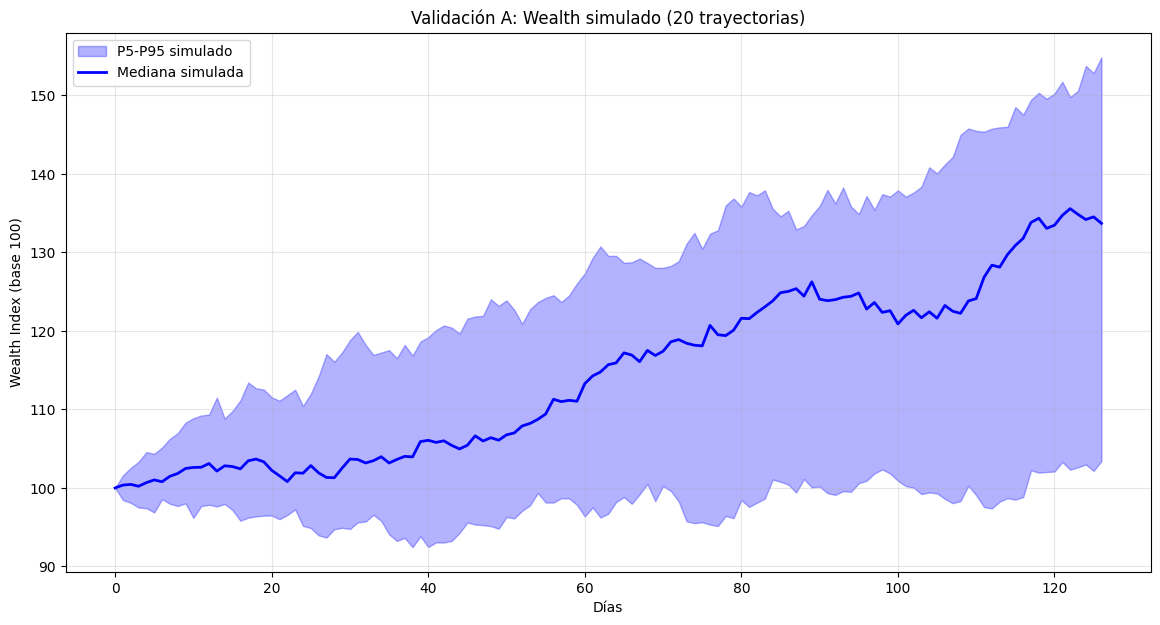

In [261]:
plt.figure(figsize=(14, 7))

dias = np.arange(HORIZONTE_DIAS + 1)
plt.fill_between(dias, p5, p95, alpha=0.3, color='blue', label='P5-P95 simulado')
plt.plot(dias, p50, 'b-', linewidth=2, label='Mediana simulada')

plt.xlabel('Días')
plt.ylabel('Wealth Index (base 100)')
plt.title(f'Validación A: Wealth simulado ({N_SIMULACIONES:,} trayectorias)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

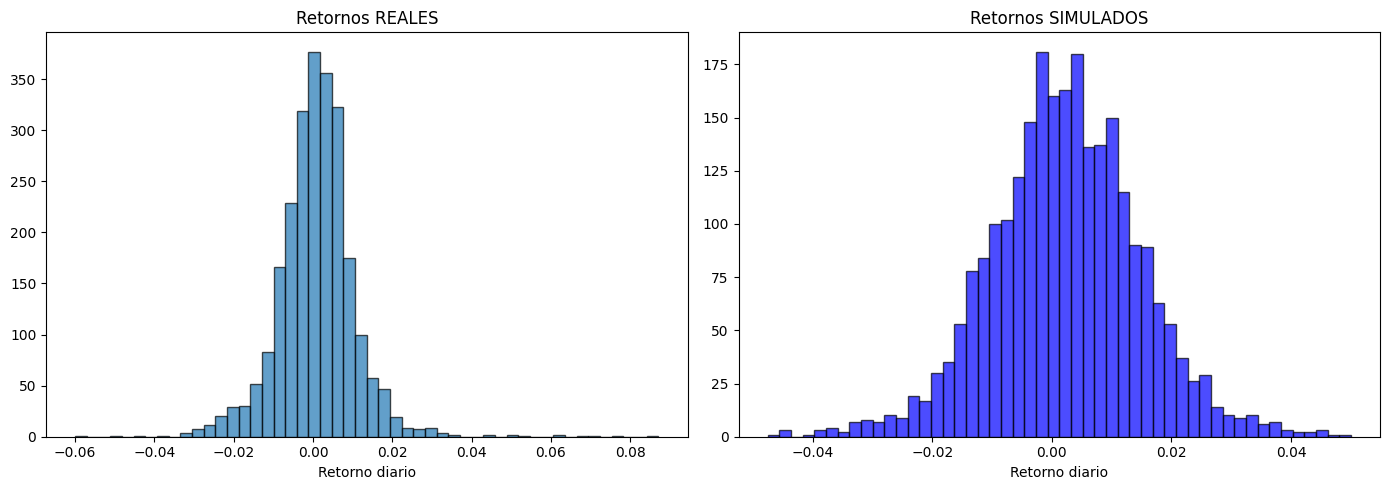

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retornos reales
axes[0].hist(retornos_cartera_real.dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Retornos REALES')
axes[0].set_xlabel('Retorno diario')

# Retornos simulados
retornos_sim_flat = (resultados['retornos'] * pesos).sum(axis=2).flatten()
axes[1].hist(retornos_sim_flat, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_title('Retornos SIMULADOS')
axes[1].set_xlabel('Retorno diario')

plt.tight_layout()
plt.show()

In [263]:
# Estadísticas de estados
def calcular_duracion_media(estados, estado_objetivo):
    duraciones = []
    contador = 0
    for s in estados:
        if s == estado_objetivo:
            contador += 1
        elif contador > 0:
            duraciones.append(contador)
            contador = 0
    return np.mean(duraciones) if duraciones else 0

# Real
estados_reales = df_final['regime'].values
pct_calma_real = (estados_reales == 0).mean()
pct_crisis_real = (estados_reales == 1).mean()
dur_calma_real = calcular_duracion_media(estados_reales, 0)
dur_crisis_real = calcular_duracion_media(estados_reales, 1)
cambios_real = np.sum(estados_reales[1:] != estados_reales[:-1])

# Simulado
estados_sim_flat = resultados['estados'].flatten()
pct_calma_sim = (estados_sim_flat == 0).mean()
pct_crisis_sim = (estados_sim_flat == 1).mean()

dur_calma_sim = np.mean([
    calcular_duracion_media(resultados['estados'][sim], 0)
    for sim in range(N_SIMULACIONES)
])

dur_crisis_sim = np.mean([
    calcular_duracion_media(resultados['estados'][sim], 1)
    for sim in range(N_SIMULACIONES)
])

cambios_sim = np.mean([
    np.sum(resultados['estados'][sim, 1:] != resultados['estados'][sim, :-1])
    for sim in range(N_SIMULACIONES)
])

# Resultados
print("Validación B: Reproducción de regímenes")
print(f"{'Métrica':<30} {'Real':<15} {'Simulado':<15}")
print("-"*60)
print(f"{'% días en Calma':<30} {pct_calma_real:>13.1%}  {pct_calma_sim:>13.1%}")
print(f"{'% días en Crisis':<30} {pct_crisis_real:>13.1%}  {pct_crisis_sim:>13.1%}")
print(f"{'Duración media Calma':<30} {dur_calma_real:>13.1f}  {dur_calma_sim:>13.1f}")
print(f"{'Duración media Crisis':<30} {dur_crisis_real:>13.1f}  {dur_crisis_sim:>13.1f}")
print(f"{'Cambios de estado':<30} {cambios_real:>13.0f}  {cambios_sim:>13.1f}")

Validación B: Reproducción de regímenes
Métrica                        Real            Simulado       
------------------------------------------------------------
% días en Calma                        85.4%          85.0%
% días en Crisis                       14.6%          15.0%
Duración media Calma                    78.5           27.7
Duración media Crisis                   13.7           11.6
Cambios de estado                        108            2.4


In [264]:
def calcular_metricas_riesgo(retornos):
    vol_diaria = np.std(retornos)
    vol_anual = vol_diaria * np.sqrt(252)
    
    wealth = (1 + retornos).cumprod()
    running_max = np.maximum.accumulate(wealth)
    drawdown = (wealth - running_max) / running_max
    max_dd = np.min(drawdown)
    
    var_99 = np.percentile(retornos, 1)
    cvar_99 = retornos[retornos <= var_99].mean()
    
    return {
        'vol_diaria': vol_diaria,
        'vol_anual': vol_anual,
        'max_drawdown': max_dd,
        'var_99': var_99,
        'cvar_99': cvar_99
    }

# Real
metricas_real = calcular_metricas_riesgo(retornos_cartera_real.dropna())

# Simulado
metricas_sim_list = []
for sim in range(N_SIMULACIONES):
    ret_sim = (resultados['retornos'][sim] * pesos).sum(axis=1)
    metricas_sim_list.append(calcular_metricas_riesgo(ret_sim))

metricas_sim = {
    k: np.mean([m[k] for m in metricas_sim_list])
    for k in metricas_real.keys()
}

# Resultados
print("Validación C: Reproducción de riesgo")
print(f"{'Métrica':<25} {'Real':<18} {'Simulado':<18}")
print("-"*65)
print(f"{'Volatilidad diaria':<25} {metricas_real['vol_diaria']:>16.4f}  {metricas_sim['vol_diaria']:>16.4f}")
print(f"{'Volatilidad anualizada':<25} {metricas_real['vol_anual']:>16.2%}  {metricas_sim['vol_anual']:>16.2%}")
print(f"{'Máximo Drawdown':<25} {metricas_real['max_drawdown']:>16.2%}  {metricas_sim['max_drawdown']:>16.2%}")
print(f"{'VaR 99%':<25} {metricas_real['var_99']:>16.4f}  {metricas_sim['var_99']:>16.4f}")
print(f"{'CVaR 99%':<25} {metricas_real['cvar_99']:>16.4f}  {metricas_sim['cvar_99']:>16.4f}")

Validación C: Reproducción de riesgo
Métrica                   Real               Simulado          
-----------------------------------------------------------------
Volatilidad diaria                  0.0101            0.0125
Volatilidad anualizada              15.98%            19.83%
Máximo Drawdown                    -14.48%            -9.60%
VaR 99%                            -0.0253           -0.0270
CVaR 99%                           -0.0311           -0.0305


In [265]:
# Separar por estado
retornos_calma_sim = []
retornos_crisis_sim = []

for sim in range(N_SIMULACIONES):
    for t in range(HORIZONTE_DIAS):
        ret_cartera = (resultados['retornos'][sim, t] * pesos).sum()
        if resultados['estados'][sim, t] == 0:
            retornos_calma_sim.append(ret_cartera)
        else:
            retornos_crisis_sim.append(ret_cartera)

vol_calma_sim = np.std(retornos_calma_sim)
vol_crisis_sim = np.std(retornos_crisis_sim)

print("Volatilidades condicionales:")
print(f"  Calma:  {vol_calma_sim:.4f}")
print(f"  Crisis: {vol_crisis_sim:.4f}")
print(f"  Ratio:  {vol_crisis_sim/vol_calma_sim:.2f}x")

Volatilidades condicionales:
  Calma:  0.0113
  Crisis: 0.0185
  Ratio:  1.64x


**FASE 5**: Escenarios de Estrés


Objetivo: "Comportamiento es estress máximo". Se reutiliza simular_trayectorias modificando:
1. Creamos una matriz de transición  forzada para que el mercado permanezca en crisis
2. Modificamos las volatilidades y medias según la narrativa económica de cada escenario

Cada escenario ejecuta N_SIMULACIONES trayectorias de HORIZONTE_DIAS días y arranca en estado de crisis (estado_inicial=1).

In [268]:
def crear_params_estres(params_base, multiplicadores_vol, shifts_media):
    """
    Modifica parámetros de crisis: multiplica volatilidad y desplaza media.
    multiplicadores_vol: dict {activo: factor}
    shifts_media: dict {activo: desplazamiento diario}
    """
    params_estres = {}
    for activo in params_base:
        params_estres[activo] = {
            'mean': params_base[activo]['mean'] + shifts_media.get(activo, 0),
            'std': params_base[activo]['std'] * multiplicadores_vol.get(activo, 1.0)
        }
    return params_estres


def crear_transicion_estres(prob_permanecer_crisis):
    """
    Matriz de transición sesgada: alta probabilidad de entrar y permanecer en crisis.
    """
    return np.array([
        [0.10, 0.90],  # Calma → Crisis con 90%
        [1 - prob_permanecer_crisis, prob_permanecer_crisis]
    ])

In [269]:
def ejecutar_escenario(nombre, trans_matrix_estres, params_calma_esc, params_crisis_esc,
                       estado_inicial=1):
    """
    Ejecuta un escenario de estrés usando N_SIMULACIONES, HORIZONTE_DIAS, SEED,
    copula_calm, copula_crisis, numeric_cols, pesos (variables globales del notebook).
    """
    np.random.seed(SEED)
    
    print(f"Ejecutando: {nombre} ({N_SIMULACIONES:,} simulaciones, {HORIZONTE_DIAS} días)...")
    
    # Simulación
    res = simular_trayectorias(
        N_SIMULACIONES, HORIZONTE_DIAS,
        trans_matrix_estres,
        params_calma_esc, params_crisis_esc,
        copula_calm, copula_crisis,
        numeric_cols,
        estado_inicial=estado_inicial
    )
    
    # Wealth de la cartera equiponderada
    wealth = np.zeros((N_SIMULACIONES, HORIZONTE_DIAS + 1))
    wealth[:, 0] = 100
    for sim in range(N_SIMULACIONES):
        ret_cartera = (res['retornos'][sim] * pesos).sum(axis=1)
        wealth[sim, 1:] = 100 * (1 + ret_cartera).cumprod()
    
    # Métricas de riesgo por trayectoria
    metricas_lista = []
    for sim in range(N_SIMULACIONES):
        ret_sim = (res['retornos'][sim] * pesos).sum(axis=1)
        metricas_lista.append(calcular_metricas_riesgo(ret_sim))
    
    metricas_promedio = {
        k: np.mean([m[k] for m in metricas_lista])
        for k in metricas_lista[0].keys()
    }
    
    # VaR y CVaR sobre todos los retornos diarios agregados
    todos_retornos = np.array([
        (res['retornos'][sim] * pesos).sum(axis=1)
        for sim in range(N_SIMULACIONES)
    ]).flatten()
    
    var_99 = np.percentile(todos_retornos, 1)
    cvar_99 = todos_retornos[todos_retornos <= var_99].mean()
    
    estados_flat = res['estados'].flatten()
    pct_crisis = (estados_flat == 1).mean()
    
    # Resumen
    print(f"  % días en Crisis:       {pct_crisis:.1%}")
    print(f"  Vol. anualizada:        {metricas_promedio['vol_anual']:.2%}")
    print(f"  Max Drawdown medio:     {metricas_promedio['max_drawdown']:.2%}")
    print(f"  VaR 99% (diario):       {var_99:.4f}")
    print(f"  CVaR 99% (diario):      {cvar_99:.4f}")
    print(f"  Wealth P5:              {np.percentile(wealth[:, -1], 5):.2f}")
    print(f"  Wealth Mediana:         {np.percentile(wealth[:, -1], 50):.2f}")
    print(f"  Prob. pérdida:          {(wealth[:, -1] < 100).mean():.1%}")
    
    return {
        'nombre': nombre,
        'resultados': res,
        'wealth': wealth,
        'metricas': metricas_promedio,
        'var_99': var_99,
        'cvar_99': cvar_99,
        'pct_crisis': pct_crisis,
        'todos_retornos': todos_retornos
    }

Clasificamos  activos para aplicar shocks diferenciados por tipo.

In [270]:
acciones_tech = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA']
acciones_financieras = ['BAC', 'JPM']
acciones_energia = ['CVX', 'XOM']
acciones_defensivas = ['JNJ', 'PG', 'BRK-B']
bonos_gob = ['DGS10_change', 'DGS2_change']
high_yield = ['BAMLH0A0HYM2_change']

ESCENARIO 1 -> ESTANFLACIÓN 2022

Suben los tipos de interes para combatir la inflación, cae el precio de los bonos, pero también car el precio de las acciones, lo cual es muy inusual. Se rompe la correlación mercado bajista->se compran más bonos y los bonos suben. 

Calibraciones de nuestro modelo

SP500 -> cae 25% en el año
bono 10 años -> cae 20% en el año (sube de 1,5 a 4,2%)
High yield spreads-> se amplian de 300 a 600 bp
Oro cae un 3%
Tecnologia muy castigadas (Amazón -50%)

In [280]:
# Escenario 1: Estanflación 2022

mult_vol_e1 = {}
shift_media_e1 = {}

for activo in numeric_cols:
    if activo in acciones_energia:
        # Energía: alta vol pero caída leve (beneficiadas por inflación)
        mult_vol_e1[activo] = 1.3
        shift_media_e1[activo] = -0.0005
    elif activo == 'GLD':
        # Oro: no funciona como refugio con tipos altos reales
        mult_vol_e1[activo] = 1.2
        shift_media_e1[activo] = -0.0003
    elif activo == 'ENPH':
        # Renovables: muy castigadas (growth + tipos)
        mult_vol_e1[activo] = 1.8
        shift_media_e1[activo] = -0.003
    elif activo in acciones_tech:
        # Tech/Growth: sensible a tipos
        mult_vol_e1[activo] = 1.5
        shift_media_e1[activo] = -0.002
    elif activo in bonos_gob:
        # Bonos gobierno: caen fuerte (tipos suben)
        mult_vol_e1[activo] = 1.8
        shift_media_e1[activo] = -0.001
    elif activo in high_yield:
        # High Yield: doble golpe (tipos + spreads)
        mult_vol_e1[activo] = 1.6
        shift_media_e1[activo] = -0.002
    else:
        # Resto de acciones
        mult_vol_e1[activo] = 1.3
        shift_media_e1[activo] = -0.001

# Matriz: crisis muy persistente (estanflación es un proceso lento)
trans_e1 = crear_transicion_estres(prob_permanecer_crisis=0.97)

# Parámetros estresados (partimos de params_crisis y amplificamos)
params_crisis_e1 = crear_params_estres(params_crisis, mult_vol_e1, shift_media_e1)

In [281]:
escenario_1 = ejecutar_escenario(
    "Estanflación 2022",
    trans_e1, params_calma, params_crisis_e1
)

Ejecutando: Estanflación 2022 (20 simulaciones, 126 días)...
  % días en Crisis:       96.9%
  Vol. anualizada:        39.42%
  Max Drawdown medio:     -27.13%
  VaR 99% (diario):       -0.0618
  CVaR 99% (diario):      -0.0686
  Wealth P5:              67.67
  Wealth Mediana:         108.40
  Prob. pérdida:          40.0%


Escenario 2 -> Crisis de Crédito 2008

Colapso del sistema financiero. Quiebra de Lehman Brother. Pánico generalizado.

Calibración basada en 2008:
- S&P 500 cayó ~57% desde máximos
- VIX alcanzó 80+
- HY spreads se dispararon a 2000bp+
- Financieras (BAC, JPM) cayeron 60-90%
- Bonos gobierno SUBIERON (flight to quality)
- Oro SUBIÓ (refugio clásico en pánico crediticio)

Diferencia clave con Escenario 1: aquí la renta fija gobierno SÍ protege.

In [282]:
# Escenario 2: Crisis de Crédito 2008

mult_vol_e2 = {}
shift_media_e2 = {}

for activo in numeric_cols:
    if activo in acciones_financieras:
        # Financieras: epicentro de la crisis
        mult_vol_e2[activo] = 2.5
        shift_media_e2[activo] = -0.005
    elif activo == 'GLD':
        # Oro: refugio en crisis crediticia
        mult_vol_e2[activo] = 1.3
        shift_media_e2[activo] = 0.001
    elif activo == 'GME':
        # Especulativa: muy castigada
        mult_vol_e2[activo] = 2.0
        shift_media_e2[activo] = -0.004
    elif activo in acciones_tech + ['ENPH']:
        # Tech: caída fuerte pero menor que financieras
        mult_vol_e2[activo] = 1.8
        shift_media_e2[activo] = -0.003
    elif activo in bonos_gob:
        # Bonos gobierno: SUBEN (flight to quality, bajan yields)
        mult_vol_e2[activo] = 1.5
        shift_media_e2[activo] = 0.0008
    elif activo in high_yield:
        # High Yield: spreads se disparan, destrucción
        mult_vol_e2[activo] = 2.5
        shift_media_e2[activo] = -0.004
    else:
        # Resto: caída generalizada
        mult_vol_e2[activo] = 1.6
        shift_media_e2[activo] = -0.002

# Matriz: crisis extrema y prolongada
trans_e2 = crear_transicion_estres(prob_permanecer_crisis=0.99)

params_crisis_e2 = crear_params_estres(params_crisis, mult_vol_e2, shift_media_e2)


In [283]:
escenario_2 = ejecutar_escenario(
    "Crisis de Crédito 2008",
    trans_e2, params_calma, params_crisis_e2
)

Ejecutando: Crisis de Crédito 2008 (20 simulaciones, 126 días)...
  % días en Crisis:       98.8%
  Vol. anualizada:        48.52%
  Max Drawdown medio:     -35.63%
  VaR 99% (diario):       -0.0756
  CVaR 99% (diario):      -0.0836
  Wealth P5:              50.02
  Wealth Mediana:         97.97
  Prob. pérdida:          50.0%


Escenario 3 (Poco probable pero no imposible y de una severidad extrema): Tormenta Solar (Evento Carrington)

Contexto: Una eyección de masa solar de magnitud histórica (tipo Evento Carrington de 1859, 
o el near-miss de 2012) impacta la Tierra. Las corrientes geomagnéticamente inducidas 
destruyen transformadores eléctricos y dañan gravemente equipos electrónicos a escala global.

Secuencia de eventos:
- Día 1-3: Apagones masivos, caída de satélites GPS, Galileo y comunicaciones
- Los mercados suspenden cotización durante 1-2 sesiones por caos operativo
- Bancos sin sistemas: cajeros inoperativos, transferencias bloqueadas
- Centros de datos dañados: pérdida de infraestructura cloud (AWS, Azure, GCP)
- Incertidumbre total sobre el estado real de los activos digitales

Impacto por tipo de activo:
- Tech (AAPL, AMZN, GOOGL, MSFT, NVDA): DESTRUCCIÓN. Dependen de centros de datos, 
  cadenas de suministro electrónico y demanda digital. NVDA especialmente: si los GPUs 
  de los datacenters se han frito, ¿qué vale una empresa de chips?
- ENPH: Doble golpe. Paneles solares y su electrónica de potencia dañados + red eléctrica caída
- Financieras (BAC, JPM): Crisis operativa severa. Sin sistemas no pueden operar, 
  pero el negocio subyacente (préstamos, depósitos) sobrevive a medio plazo
- Energía fósil (CVX, XOM): BENEFICIADAS. El petróleo y gas no necesitan electrónica 
  para existir. Demanda masiva de generadores diésel, infraestructura analógica
- Oro (GLD): REFUGIO MÁXIMO. Activo físico por excelencia, no depende de electrónica.
  Pánico extremo
- Defensivas (JNJ, PG, BRK-B): Caen pero menos. La gente sigue necesitando jabón y medicinas
- Bonos gobierno: Suben. De los pocos refugios que quedan
- High Yield: Se desploma. Empresas endeudadas sin sistemas no pueden operar ni pagar

La NASA confirmó que en julio de 2012 la Tierra esquivó por una semana un evento de 
magnitud comparable al Carrington. Es un escenario con probabilidad baja pero no nula.

In [284]:
# Escenario 3: Tormenta Solar Extrema

mult_vol_e3 = {}
shift_media_e3 = {}

for activo in numeric_cols:
    if activo == 'NVDA':
        # NVDA: la más afectada. GPUs de datacenters destruidos, razón de ser cuestionada
        mult_vol_e3[activo] = 3.0
        shift_media_e3[activo] = -0.006
    elif activo in ['AAPL', 'AMZN', 'GOOGL', 'MSFT']:
        # Big Tech: centros de datos dañados, cloud caído, cadena de suministro rota
        mult_vol_e3[activo] = 2.5
        shift_media_e3[activo] = -0.005
    elif activo == 'ENPH':
        # Renovables: electrónica de potencia frita + red eléctrica caída
        mult_vol_e3[activo] = 2.8
        shift_media_e3[activo] = -0.005
    elif activo in ['BAC', 'JPM']:
        # Financieras: sin sistemas pero negocio subyacente sobrevive
        mult_vol_e3[activo] = 2.0
        shift_media_e3[activo] = -0.003
    elif activo in ['CVX', 'XOM']:
        # Energía fósil: BENEFICIADAS. Petróleo/gas no necesitan electrónica para existir
        # Demanda masiva de generadores diésel y combustible
        mult_vol_e3[activo] = 1.8
        shift_media_e3[activo] = 0.003
    elif activo == 'GLD':
        # Oro: REFUGIO MÁXIMO. Activo físico, no depende de electrónica
        # Pánico extremo → todo el mundo quiere hard assets
        mult_vol_e3[activo] = 1.5
        shift_media_e3[activo] = 0.003
    elif activo == 'GME':
        # Especulativa: sin plataformas de trading retail, se hunde
        mult_vol_e3[activo] = 2.5
        shift_media_e3[activo] = -0.005
    elif activo in ['JNJ', 'PG']:
        # Defensivas: la gente sigue necesitando jabón y medicinas
        mult_vol_e3[activo] = 1.3
        shift_media_e3[activo] = -0.001
    elif activo == 'BRK-B':
        # Berkshire: diversificada, tiene seguros (pagarán siniestros) pero también energía
        mult_vol_e3[activo] = 1.5
        shift_media_e3[activo] = -0.002
    elif activo in bonos_gob:
        # Bonos gobierno: flight to quality extremo, el gobierno es último respaldo
        mult_vol_e3[activo] = 1.3
        shift_media_e3[activo] = 0.001
    elif activo in high_yield:
        # HY: empresas endeudadas sin sistemas no pueden operar ni pagar deuda
        mult_vol_e3[activo] = 2.5
        shift_media_e3[activo] = -0.004
    else:
        mult_vol_e3[activo] = 1.8
        shift_media_e3[activo] = -0.003

# Crisis extremadamente persistente: no se arreglan transformadores en semanas
# La recuperación de infraestructura eléctrica y de datos tardaría meses
trans_e3 = crear_transicion_estres(prob_permanecer_crisis=0.99)

params_crisis_e3 = crear_params_estres(params_crisis, mult_vol_e3, shift_media_e3)

In [285]:
escenario_3 = ejecutar_escenario(
    "Tormenta Solar Extrema (Evento Carrington)",
    trans_e3, params_calma, params_crisis_e3
)

Ejecutando: Tormenta Solar Extrema (Evento Carrington) (20 simulaciones, 126 días)...
  % días en Crisis:       98.8%
  Vol. anualizada:        57.33%
  Max Drawdown medio:     -39.23%
  VaR 99% (diario):       -0.0863
  CVaR 99% (diario):      -0.0969
  Wealth P5:              42.45
  Wealth Mediana:         105.29
  Prob. pérdida:          45.0%


Escenario 4 (un extra más probable que el anterior): Shock Geopolítico 

Contexto: Escalada geopolítica severa en el conflicto en Taiwán .
Interrupción de cadenas de suministro de semiconductore.

Justificación económica:
- Crisis de semiconductores → tech colapsa (NVDA, AAPL dependen de TSMC)
- Incertidumbre extrema → VIX > 50
- Oro: refugio clásico en conflicto geopolítico → sube
- Bonos gobierno: efecto mixto (flight to quality vs expectativa de inflación)
- Defensivas (JNJ, PG): caen menos, demanda inelástica

Este escenario es relevante porque la concentración del portafolio en mega-cap tech
lo hace especialmente vulnerable a disrupciones de semiconductores, un riesgo que 
los modelos de correlación estática no capturan.

In [286]:
# Escenario 4: Shock Geopolítico 

mult_vol_e4 = {}
shift_media_e4 = {}

for activo in numeric_cols:
    if activo in acciones_tech:
        # Tech: golpe directo por semiconductores
        mult_vol_e4[activo] = 2.2
        shift_media_e4[activo] = -0.004
    elif activo == 'ENPH':
        # Renovables: afectadas por cadena de suministro
        mult_vol_e4[activo] = 2.0
        shift_media_e4[activo] = -0.003
    elif activo in acciones_energia:
        # Energía fósil: BENEFICIADAS por shock de oferta
        mult_vol_e4[activo] = 2.0
        shift_media_e4[activo] = 0.002
    elif activo == 'GLD':
        # Oro: refugio en conflicto geopolítico
        mult_vol_e4[activo] = 1.4
        shift_media_e4[activo] = 0.0015
    elif activo in acciones_financieras:
        # Financieras: incertidumbre pero no crisis crediticia directa
        mult_vol_e4[activo] = 1.6
        shift_media_e4[activo] = -0.002
    elif activo == 'GME':
        mult_vol_e4[activo] = 2.0
        shift_media_e4[activo] = -0.003
    elif activo in bonos_gob:
        # Bonos: efecto mixto
        mult_vol_e4[activo] = 1.4
        shift_media_e4[activo] = 0.0003
    elif activo in high_yield:
        # HY: ampliación de spreads
        mult_vol_e4[activo] = 1.8
        shift_media_e4[activo] = -0.002
    elif activo in acciones_defensivas:
        # Defensivas: caen menos
        mult_vol_e4[activo] = 1.2
        shift_media_e4[activo] = -0.0005
    else:
        mult_vol_e4[activo] = 1.5
        shift_media_e4[activo] = -0.002

# Crisis aguda pero potencialmente más corta que 2008
trans_e4 = crear_transicion_estres(prob_permanecer_crisis=0.96)

params_crisis_e4 = crear_params_estres(params_crisis, mult_vol_e4, shift_media_e4)



In [287]:
escenario_4 = ejecutar_escenario(
    "Shock Geopolítico",
    trans_e4, params_calma, params_crisis_e4
)

Ejecutando: Shock Geopolítico (20 simulaciones, 126 días)...
  % días en Crisis:       95.9%
  Vol. anualizada:        48.63%
  Max Drawdown medio:     -33.00%
  VaR 99% (diario):       -0.0758
  CVaR 99% (diario):      -0.0831
  Wealth P5:              58.45
  Wealth Mediana:         113.13
  Prob. pérdida:          45.0%


**A repasar, toto esto me lo ha hecho Claude**


Me parece que es correcto, pero hay que mirarlo con un poco más de detalle.

Comparación visual de los cuatro escenarios: evolución del wealth (P5-P50-P95)

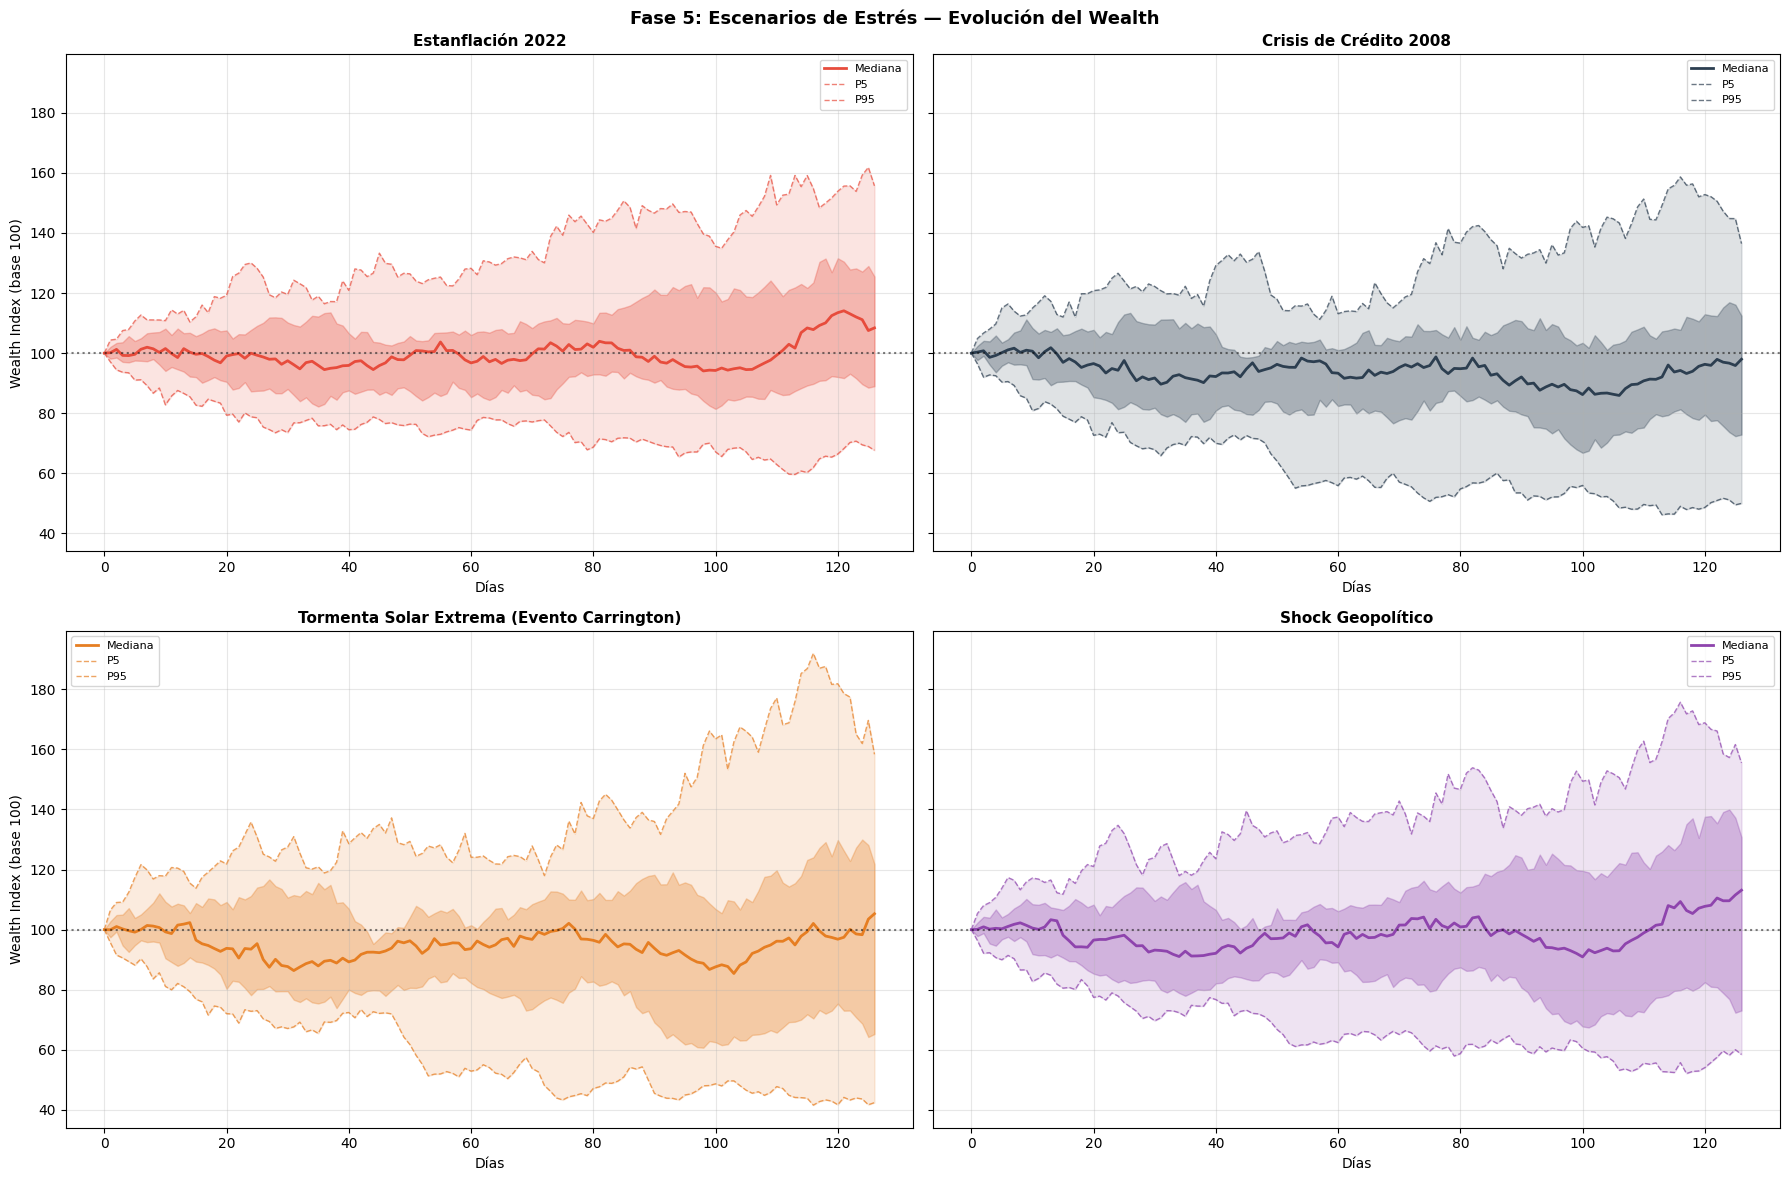

In [288]:
escenarios = [escenario_1, escenario_2, escenario_3, escenario_4]
colores = ['#e74c3c', '#2c3e50', '#e67e22', '#8e44ad']

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=True)
axes = axes.flatten()

for idx, (esc, color) in enumerate(zip(escenarios, colores)):
    ax = axes[idx]
    w = esc['wealth']
    dias = np.arange(w.shape[1])
    
    p5 = np.percentile(w, 5, axis=0)
    p25 = np.percentile(w, 25, axis=0)
    p50 = np.percentile(w, 50, axis=0)
    p75 = np.percentile(w, 75, axis=0)
    p95 = np.percentile(w, 95, axis=0)
    
    ax.fill_between(dias, p5, p95, alpha=0.15, color=color)
    ax.fill_between(dias, p25, p75, alpha=0.3, color=color)
    ax.plot(dias, p50, color=color, linewidth=2, label='Mediana')
    ax.plot(dias, p5, '--', color=color, alpha=0.7, linewidth=1, label='P5')
    ax.plot(dias, p95, '--', color=color, alpha=0.7, linewidth=1, label='P95')
    ax.axhline(100, color='black', linestyle=':', alpha=0.5)
    
    ax.set_title(esc['nombre'], fontsize=11, fontweight='bold')
    ax.set_xlabel('Días')
    if idx % 2 == 0:
        ax.set_ylabel('Wealth Index (base 100)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Fase 5: Escenarios de Estrés — Evolución del Wealth', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

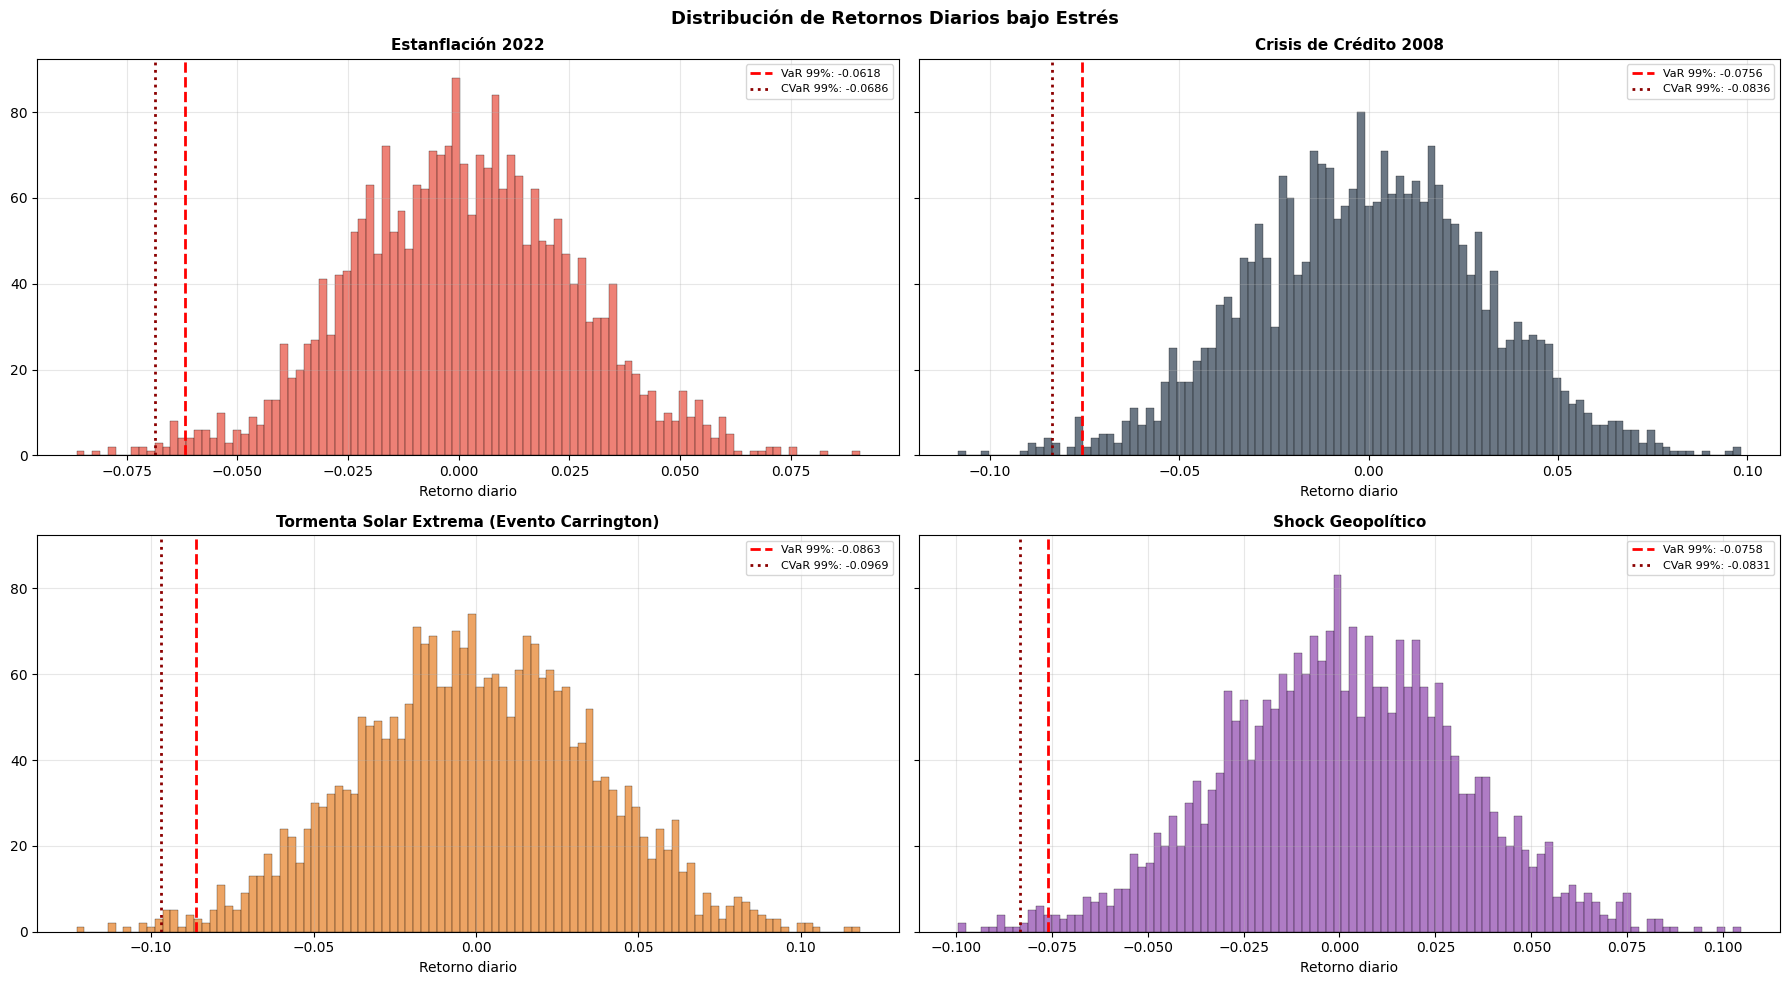

In [289]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for idx, (esc, color) in enumerate(zip(escenarios, colores)):
    ax = axes[idx]
    ax.hist(esc['todos_retornos'], bins=100, alpha=0.7, color=color, edgecolor='black', linewidth=0.3)
    ax.axvline(esc['var_99'], color='red', linewidth=2, linestyle='--', 
               label=f"VaR 99%: {esc['var_99']:.4f}")
    ax.axvline(esc['cvar_99'], color='darkred', linewidth=2, linestyle=':', 
               label=f"CVaR 99%: {esc['cvar_99']:.4f}")
    ax.set_title(esc['nombre'], fontsize=11, fontweight='bold')
    ax.set_xlabel('Retorno diario')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribución de Retornos Diarios bajo Estrés', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Distribución del wealth final: los cuatro escenarios superpuestos

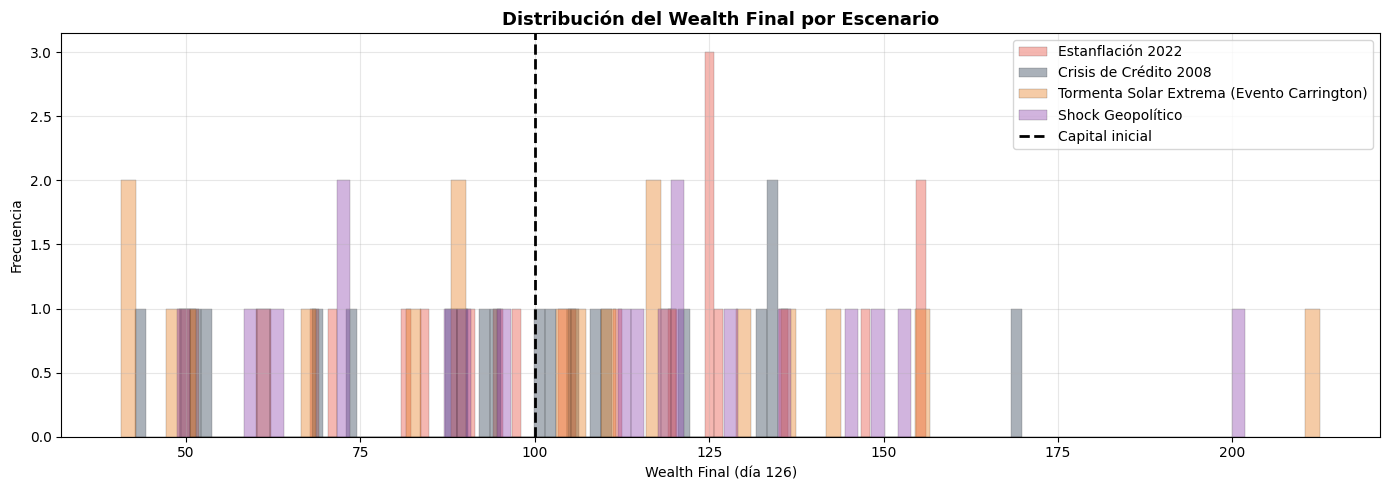

In [290]:
fig, ax = plt.subplots(figsize=(14, 5))

for esc, color in zip(escenarios, colores):
    ax.hist(esc['wealth'][:, -1], bins=80, alpha=0.4, color=color, 
            edgecolor='black', linewidth=0.3, label=esc['nombre'])

ax.axvline(100, color='black', linewidth=2, linestyle='--', label='Capital inicial')
ax.set_xlabel('Wealth Final (día 126)')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución del Wealth Final por Escenario', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Simulación base para comparar (mismos parámetros que Fase 4)

In [291]:
# Simulación base con las mismas condiciones
np.random.seed(SEED)
resultados_base = simular_trayectorias(
    N_SIMULACIONES, HORIZONTE_DIAS,
    transition_matrix, params_calma, params_crisis,
    copula_calm, copula_crisis,
    numeric_cols, estado_inicial=0
)

# Métricas base
ret_base_all = np.array([
    (resultados_base['retornos'][sim] * pesos).sum(axis=1)
    for sim in range(N_SIMULACIONES)
]).flatten()

metricas_base_list = []
for sim in range(N_SIMULACIONES):
    ret_sim = (resultados_base['retornos'][sim] * pesos).sum(axis=1)
    metricas_base_list.append(calcular_metricas_riesgo(ret_sim))

metricas_base = {k: np.mean([m[k] for m in metricas_base_list]) for k in metricas_base_list[0].keys()}
var_base = np.percentile(ret_base_all, 1)
cvar_base = ret_base_all[ret_base_all <= var_base].mean()

wealth_base = np.zeros((N_SIMULACIONES, HORIZONTE_DIAS + 1))
wealth_base[:, 0] = 100
for sim in range(N_SIMULACIONES):
    ret_c = (resultados_base['retornos'][sim] * pesos).sum(axis=1)
    wealth_base[sim, 1:] = 100 * (1 + ret_c).cumprod()

Tabla comparativa Base vs Escenarios de Estrés

In [292]:
print("TABLA RESUMEN: BASE vs ESCENARIOS DE ESTRÉS")
print("="*105)
print(f"{'Métrica':<28} {'Base':<15} {'E1: Estanfl.':<15} {'E2: Crédito':<15} {'E3: Geopol.':<15} {'E4: Solar':<15}")
print("─"*103)

rows = [
    ("% días en Crisis", 
     f"{(resultados_base['estados'].flatten()==1).mean():.1%}",
     f"{escenario_1['pct_crisis']:.1%}",
     f"{escenario_2['pct_crisis']:.1%}",
     f"{escenario_3['pct_crisis']:.1%}",
     f"{escenario_4['pct_crisis']:.1%}"),
    ("Vol. anualizada",
     f"{metricas_base['vol_anual']:.2%}",
     f"{escenario_1['metricas']['vol_anual']:.2%}",
     f"{escenario_2['metricas']['vol_anual']:.2%}",
     f"{escenario_3['metricas']['vol_anual']:.2%}",
     f"{escenario_4['metricas']['vol_anual']:.2%}"),
    ("Max Drawdown (medio)",
     f"{metricas_base['max_drawdown']:.2%}",
     f"{escenario_1['metricas']['max_drawdown']:.2%}",
     f"{escenario_2['metricas']['max_drawdown']:.2%}",
     f"{escenario_3['metricas']['max_drawdown']:.2%}",
     f"{escenario_4['metricas']['max_drawdown']:.2%}"),
    ("VaR 99% (diario)",
     f"{var_base:.4f}",
     f"{escenario_1['var_99']:.4f}",
     f"{escenario_2['var_99']:.4f}",
     f"{escenario_3['var_99']:.4f}",
     f"{escenario_4['var_99']:.4f}"),
    ("CVaR 99% (diario)",
     f"{cvar_base:.4f}",
     f"{escenario_1['cvar_99']:.4f}",
     f"{escenario_2['cvar_99']:.4f}",
     f"{escenario_3['cvar_99']:.4f}",
     f"{escenario_4['cvar_99']:.4f}"),
    ("Wealth P5 (día 126)",
     f"{np.percentile(wealth_base[:,-1], 5):.1f}",
     f"{np.percentile(escenario_1['wealth'][:,-1], 5):.1f}",
     f"{np.percentile(escenario_2['wealth'][:,-1], 5):.1f}",
     f"{np.percentile(escenario_3['wealth'][:,-1], 5):.1f}",
     f"{np.percentile(escenario_4['wealth'][:,-1], 5):.1f}"),
    ("Wealth Mediana (día 126)",
     f"{np.percentile(wealth_base[:,-1], 50):.1f}",
     f"{np.percentile(escenario_1['wealth'][:,-1], 50):.1f}",
     f"{np.percentile(escenario_2['wealth'][:,-1], 50):.1f}",
     f"{np.percentile(escenario_3['wealth'][:,-1], 50):.1f}",
     f"{np.percentile(escenario_4['wealth'][:,-1], 50):.1f}"),
    ("Prob. pérdida",
     f"{(wealth_base[:,-1]<100).mean():.1%}",
     f"{(escenario_1['wealth'][:,-1]<100).mean():.1%}",
     f"{(escenario_2['wealth'][:,-1]<100).mean():.1%}",
     f"{(escenario_3['wealth'][:,-1]<100).mean():.1%}",
     f"{(escenario_4['wealth'][:,-1]<100).mean():.1%}"),
]

for nombre, *vals in rows:
    print(f"{nombre:<28} {vals[0]:<15} {vals[1]:<15} {vals[2]:<15} {vals[3]:<15} {vals[4]:<15}")

print("─"*103)

TABLA RESUMEN: BASE vs ESCENARIOS DE ESTRÉS
Métrica                      Base            E1: Estanfl.    E2: Crédito     E3: Geopol.     E4: Solar      
───────────────────────────────────────────────────────────────────────────────────────────────────────
% días en Crisis             15.0%           96.9%           98.8%           98.8%           95.9%          
Vol. anualizada              19.83%          39.42%          48.52%          57.33%          48.63%         
Max Drawdown (medio)         -9.60%          -27.13%         -35.63%         -39.23%         -33.00%        
VaR 99% (diario)             -0.0306         -0.0618         -0.0756         -0.0863         -0.0758        
CVaR 99% (diario)            -0.0360         -0.0686         -0.0836         -0.0969         -0.0831        
Wealth P5 (día 126)          103.4           67.7            50.0            42.5            58.5           
Wealth Mediana (día 126)     133.7           108.4           98.0            105.3       

Validación por escenario: regímenes, métricas de riesgo y volatilidades condicionales

In [293]:
for esc in escenarios:
    print(f"\nVALIDACIÓN — {esc['nombre']}")
    print("="*60)
    
    estados = esc['resultados']['estados']
    pct_crisis = (estados.flatten() == 1).mean()
    
    # Duraciones medias (reutilizamos calcular_duracion_media de Fase 4)
    dur_crisis_list = []
    dur_calma_list = []
    cambios_list = []
    
    for sim in range(N_SIMULACIONES):
        e = estados[sim]
        cambios_list.append(np.sum(e[1:] != e[:-1]))
        
        dur_c = calcular_duracion_media(e, 0)
        dur_k = calcular_duracion_media(e, 1)
        if dur_c > 0:
            dur_calma_list.append(dur_c)
        if dur_k > 0:
            dur_crisis_list.append(dur_k)
    
    print(f"  % días en Crisis:       {pct_crisis:.1%}")
    print(f"  Duración media Calma:   {np.mean(dur_calma_list) if dur_calma_list else 0:.1f} días")
    print(f"  Duración media Crisis:  {np.mean(dur_crisis_list):.1f} días")
    print(f"  Cambios de estado:      {np.mean(cambios_list):.1f}")
    print(f"  Vol. anualizada:        {esc['metricas']['vol_anual']:.2%}")
    print(f"  Max Drawdown medio:     {esc['metricas']['max_drawdown']:.2%}")
    print(f"  VaR 99% (diario):       {esc['var_99']:.4f}")
    print(f"  CVaR 99% (diario):      {esc['cvar_99']:.4f}")
    
    # Volatilidades condicionales
    ret_calma = []
    ret_crisis = []
    for sim in range(N_SIMULACIONES):
        for t in range(HORIZONTE_DIAS):
            r = (esc['resultados']['retornos'][sim, t] * pesos).sum()
            if esc['resultados']['estados'][sim, t] == 0:
                ret_calma.append(r)
            else:
                ret_crisis.append(r)
    
    if ret_calma:
        print(f"  Vol. Calma:             {np.std(ret_calma):.4f}")
    print(f"  Vol. Crisis:            {np.std(ret_crisis):.4f}")
    if ret_calma:
        print(f"  Ratio Crisis/Calma:     {np.std(ret_crisis)/np.std(ret_calma):.2f}x")


VALIDACIÓN — Estanflación 2022
  % días en Crisis:       96.9%
  Duración media Calma:   1.1 días
  Duración media Crisis:  31.8 días
  Cambios de estado:      7.3
  Vol. anualizada:        39.42%
  Max Drawdown medio:     -27.13%
  VaR 99% (diario):       -0.0618
  CVaR 99% (diario):      -0.0686
  Vol. Calma:             0.0117
  Vol. Crisis:            0.0253
  Ratio Crisis/Calma:     2.16x

VALIDACIÓN — Crisis de Crédito 2008
  % días en Crisis:       98.8%
  Duración media Calma:   1.1 días
  Duración media Crisis:  48.5 días
  Cambios de estado:      2.8
  Vol. anualizada:        48.52%
  Max Drawdown medio:     -35.63%
  VaR 99% (diario):       -0.0756
  CVaR 99% (diario):      -0.0836
  Vol. Calma:             0.0124
  Vol. Crisis:            0.0309
  Ratio Crisis/Calma:     2.49x

VALIDACIÓN — Tormenta Solar Extrema (Evento Carrington)
  % días en Crisis:       98.8%
  Duración media Calma:   1.1 días
  Duración media Crisis:  48.5 días
  Cambios de estado:      2.8
  Vol. an